In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import root_pandas as rp
import uproot as ur
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ROOT
from analysis import analysis
import array
import matplotlib
matplotlib.rcParams['text.usetex'] = False
from scipy.stats import norm
from matplotlib import rc
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

Welcome to JupyROOT 6.22/02


# Start by determining cuts

Initialize analysis class with no cuts, keeping all events. Restrict extended virtual readout chip (VRC) to actual fiducial area of chip for accurate data/MC ratios

In [2]:
a = analysis(E_cut = 0, recoils_only = False, fei4_restrict = True)

In [3]:
LER_cont_inj = a.get_tpc_data_during_study_period("LER", "Cont_inj")
LER_decay = a.get_tpc_data_during_study_period("LER", "Decay")
HER_cont_inj = a.get_tpc_data_during_study_period("HER", "Cont_inj")
HER_decay = a.get_tpc_data_during_study_period("HER", "Decay")
Lumi_cont_inj = a.get_tpc_data_during_study_period("Lumi", "Cont_inj")
Lumi_decay = a.get_tpc_data_during_study_period("Lumi", "Decay")
Lumi = {}
HER = {}
LER = {}
Single_beam = {}
Lumi_all = {}
HER_all = {}
LER_all = {}
Single_beam_all = {}
data = {} #ALL DATA TOGETHER FOR CALIBRATION

MC = a.MC_data

for tpc in Lumi_decay.keys():
    Lumi_all[tpc] = Lumi_decay[tpc].append(Lumi_cont_inj[tpc])
    HER_all[tpc] = HER_decay[tpc].append(HER_cont_inj[tpc])
    LER_all[tpc] = LER_decay[tpc].append(LER_cont_inj[tpc])
    Single_beam_all[tpc] = LER_all[tpc].append(HER_all[tpc])
    data[tpc] = Lumi_all[tpc].append(Single_beam_all[tpc])
    
    Lumi[tpc] = Lumi_cont_inj[tpc]
    HER[tpc] = HER_cont_inj[tpc]
    LER[tpc] = LER_cont_inj[tpc]
    Single_beam[tpc] = LER[tpc].append(HER[tpc])
    
    #Lumi[tpc] = Lumi_decay[tpc]
    #HER[tpc] = HER_decay[tpc]
    #LER[tpc] = LER_decay[tpc]
    #Single_beam[tpc] = LER[tpc].append(HER[tpc])
    
    Lumi[tpc].index = [i for i in range(0,len(Lumi[tpc]))]
    Single_beam[tpc].index = [i for i in range(0,len(Single_beam[tpc]))]
    data[tpc].index = [i for i in range(0,len(data[tpc]))]
    #MC[tpc] = MC[tpc].loc[(MC[tpc]['is_recoil']==1)]

### Tune xray veto using MC

In [44]:
E = np.linspace(0,20,101)
efficiency = {}
purity = {}
tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
pos = ['z=-5.6m', 'z=+6.6m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
for tpc in tpcs:
    efficiency[tpc] = []
    purity[tpc]=[]
    for i in E: #is_reocil ==1 means events passed the cuts
        efficiency[tpc].append(MC[tpc].loc[(MC[tpc]['PDG']>1e6)&(MC[tpc]['is_recoil']==1)&(MC[tpc]['reco_energy']>i)]['ones'].sum()/MC[tpc].loc[MC[tpc]['PDG']>1e6]['ones'].sum())
        purity[tpc].append(MC[tpc].loc[(MC[tpc]['PDG']>1e6)&(MC[tpc]['reco_energy']>i)&(MC[tpc]['is_recoil']==1)]['ones'].sum()/MC[tpc].loc[(MC[tpc]['reco_energy']>i)&(MC[tpc]['is_recoil']==1)]['ones'].sum())

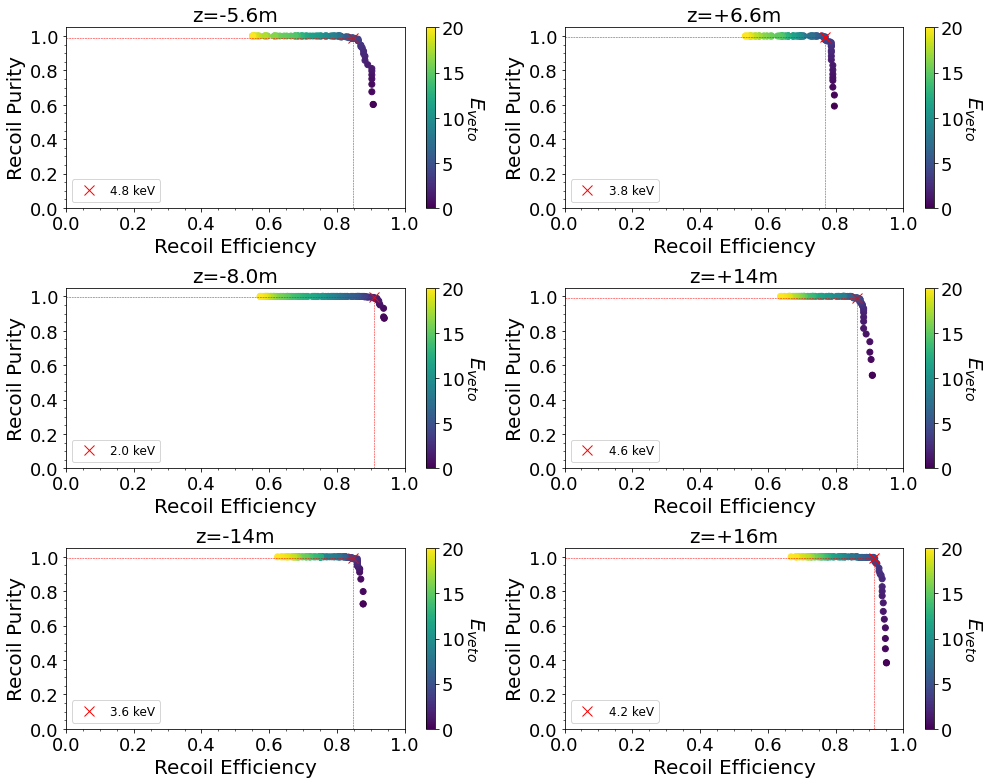

In [49]:
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (14,11))
i=1
pos = ['z=-5.6m', 'z=+6.6m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
crit = {}
axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1], ax[2,0], ax[2,1]]
for tpc in tpcs:
    df = pd.DataFrame()
    df['E'] = E
    df['purity'] = purity[tpc]
    df['efficiency'] = efficiency[tpc]
    df['FOM'] = df['purity']
    #print(df)
    crit[tpc] = df.loc[df['FOM']>0.99]['E'].min()
    loc = df.loc[df['E']==crit[tpc]].index.to_numpy()
    #plt.subplot(3,2,i)
    c=axs[i-1].scatter(efficiency[tpc],purity[tpc],c=E)#,norm=matplotlib.colors.LogNorm(vmin = 1, vmax = 20))
    axs[i-1].plot(df['efficiency'][loc],df['purity'][loc],'x',markersize = 10,color = 'red',label='%s keV'%(round(crit[tpc],2))) 
    axs[i-1].hlines(df['purity'][loc], 0,df['efficiency'][loc],linestyle='--',lw = 0.5, color = 'red') 
    axs[i-1].vlines(df['efficiency'][loc], 0,df['purity'][loc],linestyle='--',lw = 0.5, color = 'red') 
    plt.colorbar(c,ax=axs[i-1]).set_label(r'$E_{veto}$',rotation=270,labelpad=20)
    axs[i-1].set_xlabel('Recoil Efficiency')
    axs[i-1].set_ylabel('Recoil Purity')
    axs[i-1].set_xlim(0,1)
    axs[i-1].set_ylim(0,1.05)
    axs[i-1].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    axs[i-1].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i-1].yaxis.set_minor_locator(AutoMinorLocator())
    axs[i-1].set_title(pos[i-1])
    axs[i-1].legend(loc='lower left')
    i+=1
plt.tight_layout()
plt.show()

### Check EvL in data and MC

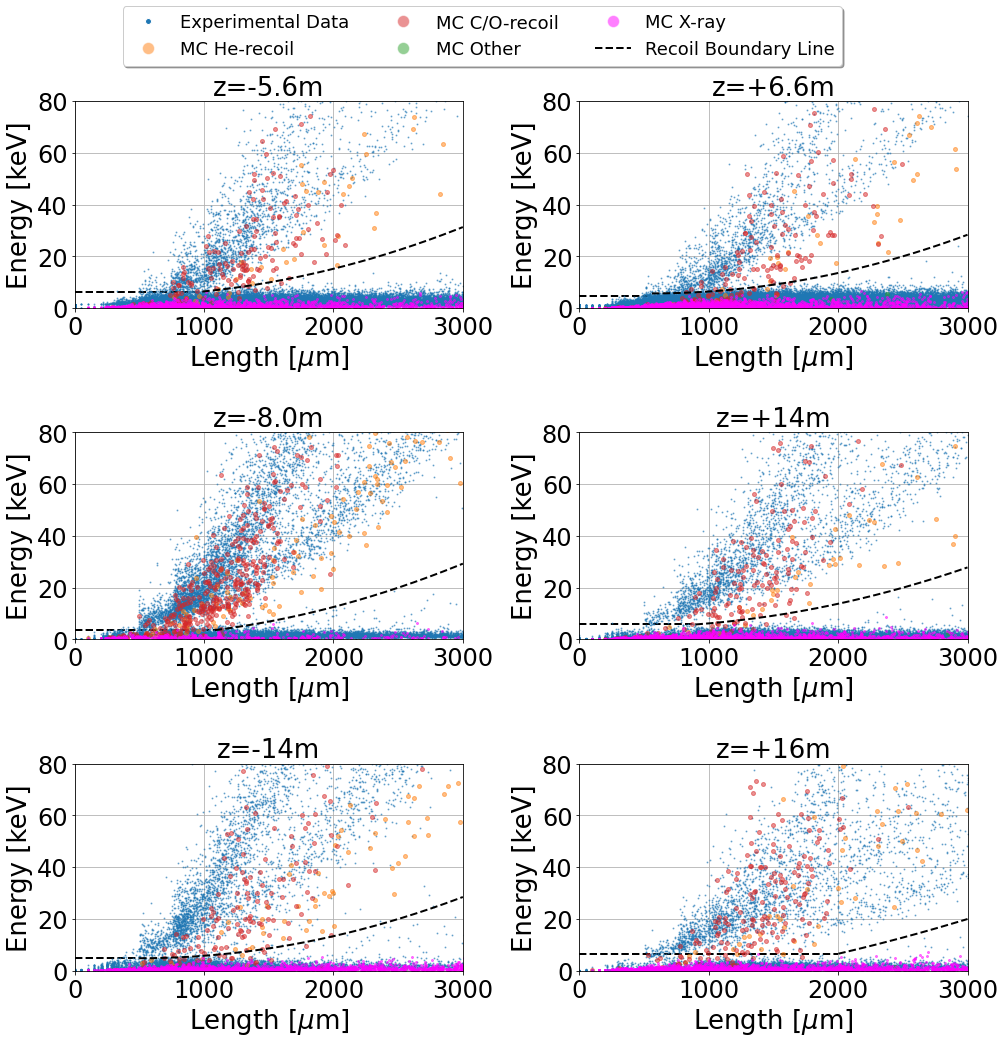

In [6]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)

x = {'iiwi': np.array([850, 2500, 15000]), 'nene': np.array([950, 2500, 16000]), 'humu': np.array([1950, 3000, 20000]),
    'palila': np.array([900, 2350, 15000]), 'tako': np.array([1400, 2500, 15000]), 'elepaio': np.array([1050, 2500, 15000])}
y = np.array([6,20,800])
cut = {}
plt.figure(figsize=(16,16))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.6)
xmax = 3000
ymax = 80
i = 1
pos = ['z=-5.6m', 'z=+6.6m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
crit = {'palila': 6.4, 'iiwi': 4.8, 'tako': 3.6, 'nene': 5.8, 'elepaio': 4.8, 'humu': 6.6}
for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    cut[tpc] = np.polyfit(x[tpc],y,2)
    x_plt = np.linspace(0,xmax,xmax+1)
    plt.subplot(3,2,i)
    plt.plot(data[tpc]['new_length'], data[tpc]['track_energy'],'o', markersize = 1, alpha = 0.5, label = 'data')
    #plt.plot(Lumi[tpc]['new_length'], Lumi[tpc]['track_energy'],'o', markersize = 1, label = 'Data')
   
    #plt.plot(Single_beam_all[tpc]['new_length'], Single_beam_all[tpc]['track_energy'],'o', markersize = 1, label = 'Data', color = 'blue')
    
    plt.plot(MC[tpc].loc[(MC[tpc]['PDG']==1000020030) & (MC[tpc]['VRC_id']>0)]['new_length'],MC[tpc].loc[(MC[tpc]['PDG']==1000020030)& (MC[tpc]['VRC_id']>0)]['reco_energy'],'o',markersize = 4, alpha = 0.5,label = 'MC_He')
    plt.plot(MC[tpc].loc[(MC[tpc]['PDG']<1000020030) & (MC[tpc]['PDG']!=11)& (MC[tpc]['VRC_id']>0)]['new_length'],MC[tpc].loc[(MC[tpc]['PDG']<1000020030) & (MC[tpc]['PDG']!=11)& (MC[tpc]['VRC_id']>0)]['reco_energy'],'o',markersize = 4, alpha = 0.5,label = 'MC_other')
    plt.plot(MC[tpc].loc[(MC[tpc]['PDG']>=1000060110)& (MC[tpc]['VRC_id']>0)]['new_length'],MC[tpc].loc[(MC[tpc]['PDG']>=1000060110)& (MC[tpc]['VRC_id']>0)]['reco_energy'],'o',markersize = 4, alpha = 0.5,label = 'MC_CO')
    plt.plot(MC[tpc].loc[MC[tpc]['PDG']==11]['new_length'],MC[tpc].loc[MC[tpc]['PDG']==11]['reco_energy'],'o',markersize = 2, alpha = 0.5,label = 'MC_x-ray',color = 'magenta')
    x_crit = 0
    for val in x_plt:
        if np.abs(cut[tpc][0]*val**2+cut[tpc][1]*val+cut[tpc][2] - crit[tpc]) < np.abs(cut[tpc][0]*x_crit**2+cut[tpc][1]*x_crit+cut[tpc][2] - crit[tpc]):
            x_crit = val
    x_plt_new = np.linspace(x_crit,xmax,100000)
    plt.plot(x_plt_new, cut[tpc][0]*x_plt_new**2+cut[tpc][1]*x_plt_new+cut[tpc][2], '--', lw = 2, color = 'black')
    plt.hlines(crit[tpc],0,x_crit, linestyle = '--', lw=2, color = 'black', label = 'Recoil boundary')
    plt.title(pos[i-1])
    
    legend_elements = [Line2D([0], [0], marker='o', color='white', label='Experimental Data',
                          markerfacecolor='tab:blue', markersize=6),
                   Line2D([0], [0], marker='o', color='white', label='MC He-recoil',
                          markerfacecolor='tab:orange', markersize=12, alpha = 0.5),
                      Line2D([0], [0], marker='o', color='white', label='MC C/O-recoil',
                          markerfacecolor='tab:red', markersize=12, alpha = 0.5),
                      Line2D([0], [0], marker='o', color='white', label='MC Other',
                          markerfacecolor='tab:green', markersize=12, alpha = 0.5),
                      Line2D([0], [0], marker='o', color='white', label='MC X-ray',
                          markerfacecolor='magenta', markersize=12, alpha = 0.5),
                      Line2D([0], [0], color='black', linestyle = '--',  lw=2, label='Recoil Boundary Line')]
    
    legend_elements2 = [Line2D([0], [0], marker='o', color='white', label='Lumi Study Data',
                          markerfacecolor='red', markersize=6),
                        Line2D([0], [0], marker='o', color='white', label='Single Beam Study Data',
                          markerfacecolor='blue', markersize=6),
                       Line2D([0], [0], color='black', linestyle = '--',  lw=2, label='Recoil Boundary Line')]
    if i == 1:
        plt.legend(handles = legend_elements, loc='upper center', bbox_to_anchor=(1.05, 1.5),
          ncol=3, fancybox=True, shadow=True)
        #plt.legend(handles = legend_elements2, loc='upper center', bbox_to_anchor=(1.05, 1.5), fancybox=True, ncol = 2, shadow=True)
    plt.grid()
    plt.ylim(0,ymax)
    plt.xlim(0,xmax)
    plt.ylabel('Energy [keV]')
    plt.xlabel(r'Length [$\mu$m]')
    i+=1
#plt.tight_layout()
plt.show()

### Generate histograms to determine purity of xray veto cuts using data

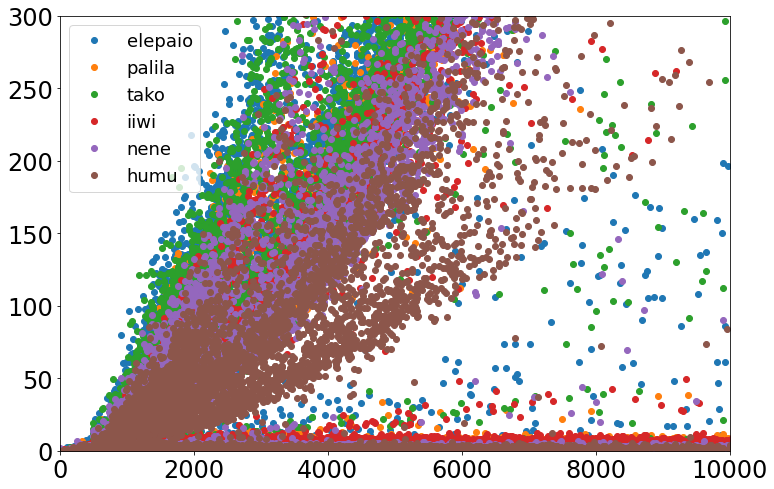

In [7]:
tpcs = ['elepaio', 'palila', 'tako', 'iiwi','nene','humu']
plt.figure(figsize=(12,8))
for tpc in tpcs:
    plt.plot(data[tpc]['new_length'], data[tpc]['track_energy'], 'o', label = tpc)
    plt.legend()
    plt.xlim(0,10000)
    plt.ylim(0,300)

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

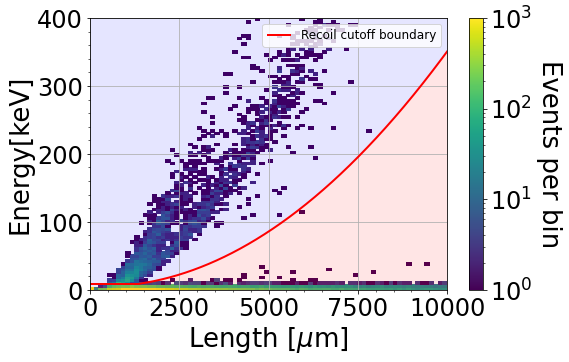

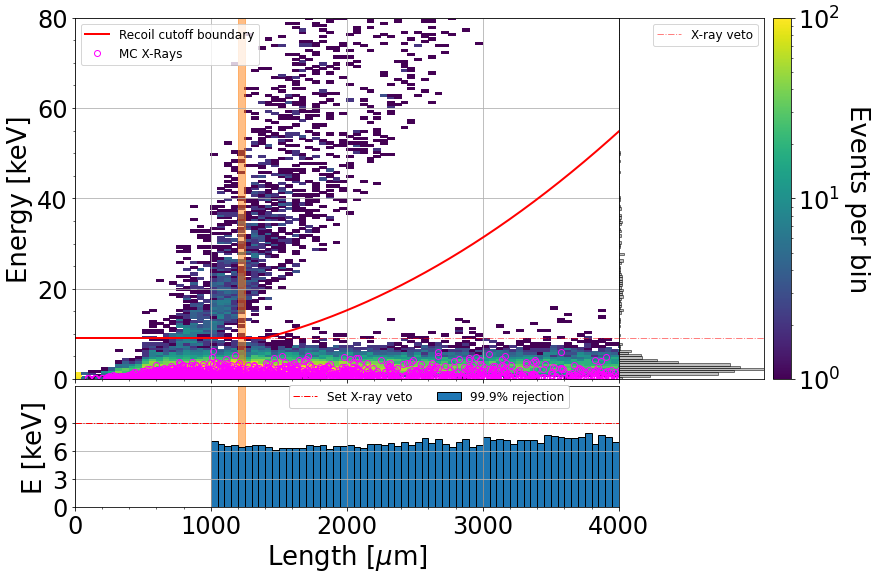

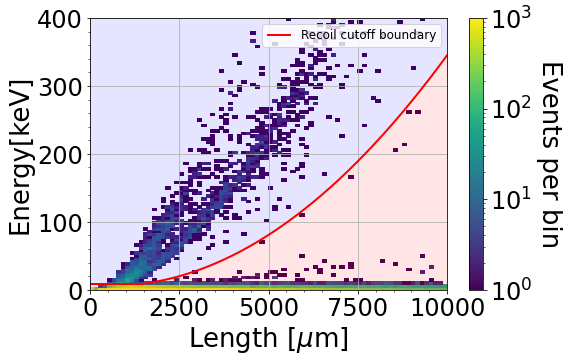

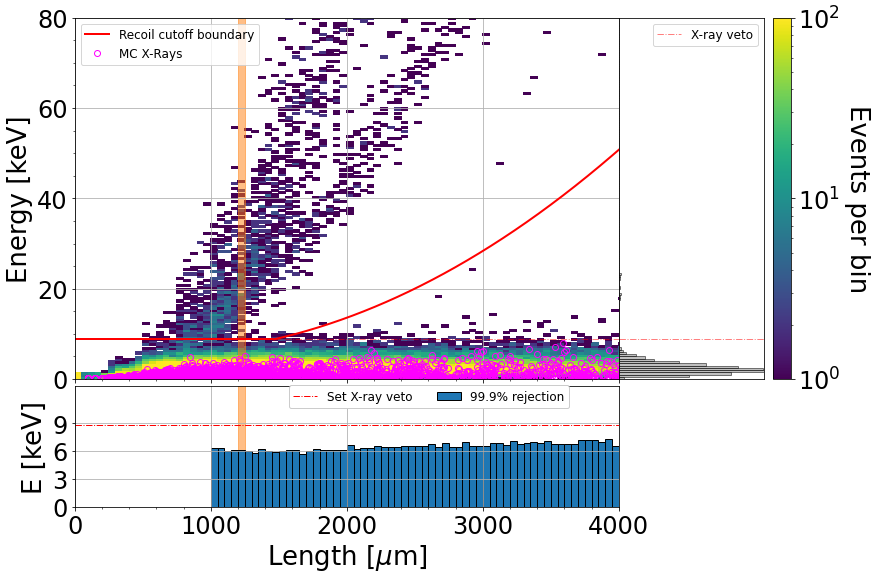

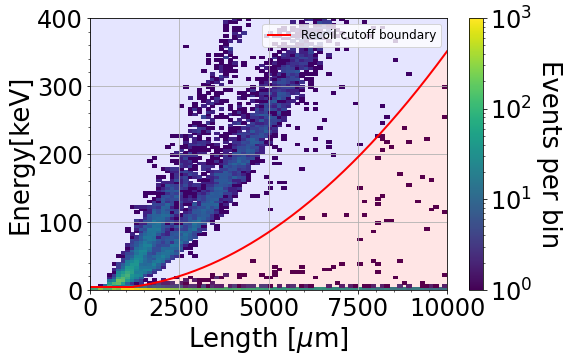

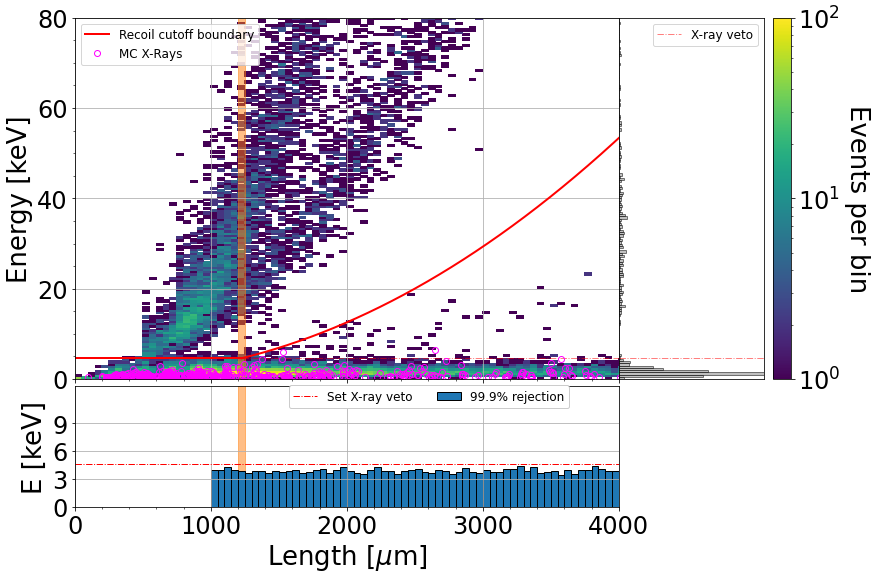

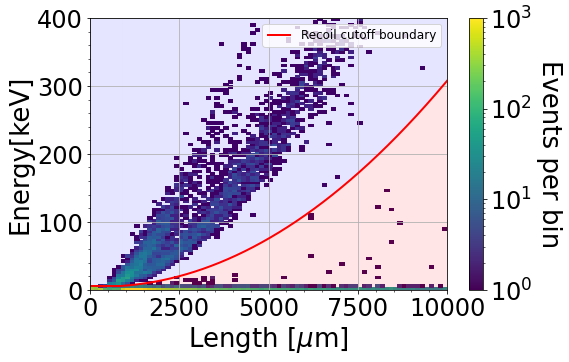

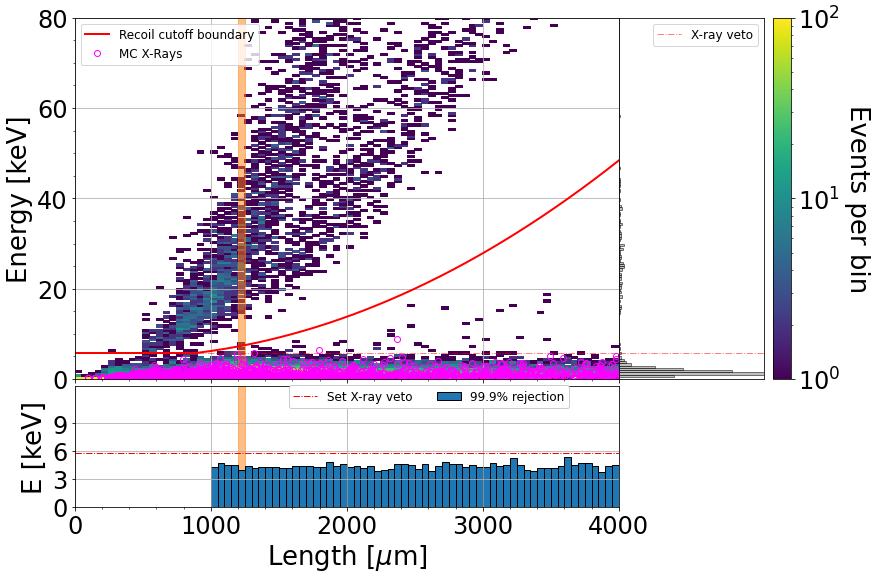

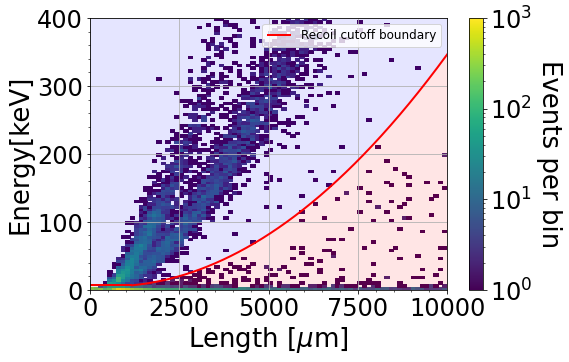

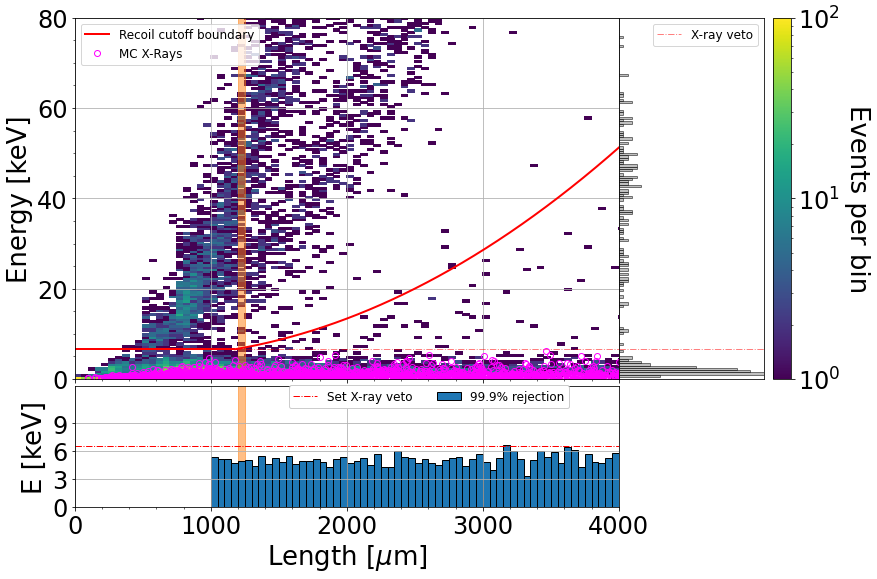

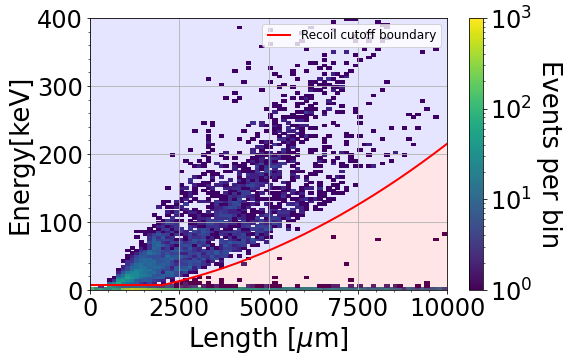

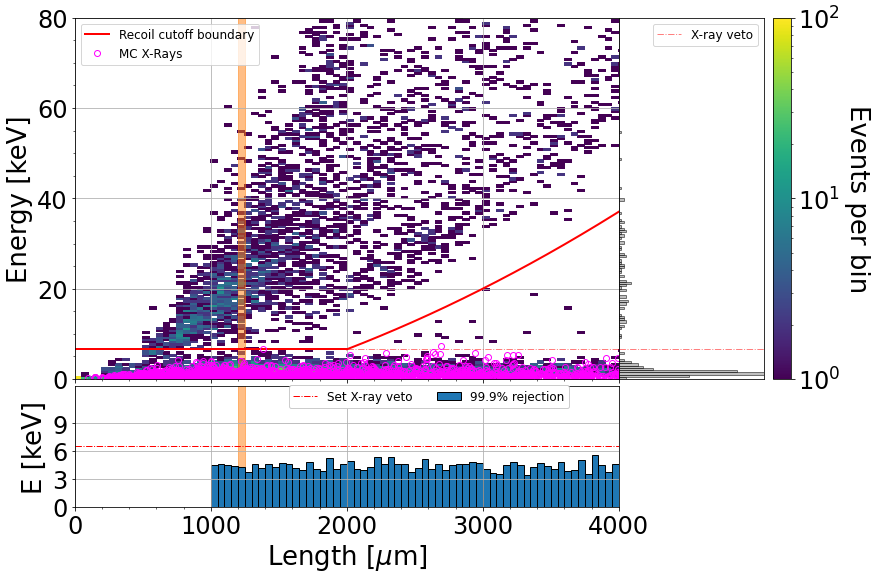

In [41]:
import warnings
warnings.filterwarnings("ignore") #suppress matplotlib warnings

# DEFINE HISTS
fig = plt.figure(figsize = (15,15))
cmap = plt.cm.viridis
cmap.set_under(color='white')
    
xm = 10000
ym = 400
nbinsx = int(xm/50)
nbinsy = int(ym*2)

xedges = {}
yedges = {}
bins = {}
h = {}
image = {}

for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    h[tpc + '_uncor'], xedges[tpc], yedges[tpc], image[tpc + '_uncor'] = plt.hist2d(Lumi[tpc]['length'], Lumi[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
    bins[tpc] = 0.5*(yedges[tpc][1:]+yedges[tpc][:-1])
plt.clf()

# CODE BELOW CREATES PLOTTED HISTOGRAMS
fig = plt.figure(figsize = (15,15))
cmap = plt.cm.viridis
cmap.set_under(color='white')
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)

#thresh = 5 #VETO THRESHOLD

xm = 10000
ym = 400
nbinsx = int(xm/50)
nbinsy = int(ym*2)


veto = {}
length = {}
sigmas = {}
e_leak = {}
veto_MC = {}
sigmas_MC = {}
e_leak_MC = {}
cut = {}
x_crit = {}

x = {'iiwi': np.array([850, 2500, 15000]), 'nene': np.array([950, 2500, 16000]), 'humu': np.array([1950, 3000, 20000]),
    'palila': np.array([900, 2350, 15000]), 'tako': np.array([1400, 2500, 15000]), 'elepaio': np.array([1050, 2500, 15000])}
y = np.array([6,20,800])

x_plt = np.linspace(0,10000,10001)
#crit = {'palila': 6.4, 'iiwi': 4.8, 'tako': 3.6, 'nene': 5.8, 'elepaio': 4.8, 'humu': 6.6}
crit = {'palila': 9.0, 'iiwi': 8.8, 'tako': 4.6, 'nene': 5.8, 'elepaio': 6.6, 'humu': 6.6}
#crit = {'palila': 8.04, 'iiwi': 10.68, 'tako': 4.56, 'nene': 9.24, 'elepaio': 7.92, 'humu': 9.24}
#crit = {'palila': 9.0, 'iiwi': 9.2, 'tako': 4.6, 'nene': 7, 'elepaio': 7, 'humu': 7}
#crit = {'palila': 9.8, 'iiwi': 9.6, 'tako': 5.2, 'nene': 6.1, 'elepaio': 6.8, 'humu': 5.9}
pos = {'palila': 'z=-5.6m', 'iiwi': 'z=+6.6m', 'tako': 'z=-8.0m', 'nene': 'z=+14m', 'elepaio': 'z=-14m', 'humu': 'z=+16m'}
for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    veto[tpc] = []
    length[tpc] = []
    sigmas[tpc] = []
    e_leak[tpc] = []
    veto_MC[tpc] = []
    sigmas_MC[tpc] = []
    e_leak_MC[tpc] = []
    i=0
    for loc in range(20,int(nbinsx*0.4)+1):
        low = bins[tpc][loc]*100-25
        high = bins[tpc][loc]*100+25
        cut[tpc] = np.polyfit(x[tpc],y,2)
        x_crit[tpc] = 0
        for val in x_plt:
            if np.abs(cut[tpc][0]*val**2+cut[tpc][1]*val+cut[tpc][2] - crit[tpc]) < np.abs(cut[tpc][0]*x_crit[tpc]**2+cut[tpc][1]*x_crit[tpc]+cut[tpc][2] - crit[tpc]):
                x_crit[tpc] = val
        #if loc >= (x_crit[tpc]/xm*nbinsx):
        #    tmp = data[tpc].loc[(data[tpc]['new_length']>low) & (data[tpc]['new_length']<=high) & (data[tpc]['track_energy'] < cut[tpc][0]*data[tpc]['new_length']**2+cut[tpc][1]*data[tpc]['new_length']+cut[tpc][2])]
        #else:
        
        ### DATA ###
        tmp = data[tpc].loc[(data[tpc]['new_length']>low) & (data[tpc]['new_length']<=high) & (data[tpc]['track_energy'] < crit[tpc])]
        length[tpc].append(bins[tpc][loc]*100)
        veto[tpc].append(tmp['track_energy'].mean() + 3*tmp['track_energy'].std())
        sigmas[tpc].append((crit[tpc]-tmp['track_energy'].mean())/tmp['track_energy'].std())
        #if loc >= (x_crit[tpc]/xm*nbinsx):
        #    e_leak[tpc].append((1-norm.cdf(sigmas[tpc][i]))*len(data[tpc].loc[(data[tpc]['track_energy'] < cut[tpc][0]*data[tpc]['new_length']**2+cut[tpc][1]*data[tpc]['new_length']+cut[tpc][2])]))
        #else:
        e_leak[tpc].append((1-norm.cdf(sigmas[tpc][i]))*len(data[tpc].loc[(data[tpc]['track_energy'] < crit[tpc])]))
        
        ### MC ###
        tmp_MC = MC[tpc].loc[(MC[tpc]['new_length']>low) & (MC[tpc]['new_length']<=high) & (MC[tpc]['reco_energy'] < crit[tpc])]
        veto_MC[tpc].append(tmp_MC['reco_energy'].mean() + 3*tmp_MC['reco_energy'].std())
        sigmas_MC[tpc].append((crit[tpc]-tmp_MC['reco_energy'].mean())/tmp_MC['reco_energy'].std())
        #if loc >= (x_crit[tpc]/xm*nbinsx):
        #    e_leak_MC[tpc].append((1-norm.cdf(sigmas_MC[tpc][i]))*len(MC[tpc].loc[(MC[tpc]['reco_energy'] < cut[tpc][0]*((MC[tpc]['new_length']))**2+cut[tpc][1]*(MC[tpc]['new_length'])+cut[tpc][2])]))
        #else:
        e_leak_MC[tpc].append((1-norm.cdf(sigmas_MC[tpc][i]))*len(MC[tpc].loc[(MC[tpc]['reco_energy'] < crit[tpc])]))#cut[tpc][0]*((MC[tpc]['new_length']))**2+cut[tpc][1]*(MC[tpc]['new_length'])+cut[tpc][2])]))
        
        i+=1

#def gauss(x,mu,sigma,A): # for gaussian fit
#    return A*exp(-(x-mu)**2/2/sigma**2)

for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    fig, ax0 = plt.subplots(figsize=(8,5))
    #ax0.set_title(pos[tpc])
    g,h,k,l = ax0.hist2d(data[tpc]['new_length'], data[tpc]['track_energy'], bins = (80,100), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
    plt.colorbar(l).set_label('Events per bin', rotation = 270, labelpad = 30)
    ax0.set_ylabel("Energy[keV]")
    ax0.set_xlabel(r'Length [$\mu$m]')
    ax0.yaxis.set_minor_locator(AutoMinorLocator())
    ax0.xaxis.set_minor_locator(AutoMinorLocator())
    x_plt = np.linspace(x_crit[tpc],10000,10001)
    ax0.plot(x_plt, cut[tpc][0]*x_plt**2 + cut[tpc][1]*x_plt + cut[tpc][2], '-', color = 'red', lw=2)
    ax0.fill_between(x_plt, 0, cut[tpc][0]*x_plt**2 + cut[tpc][1]*x_plt + cut[tpc][2], '-', color = 'red', lw=0, alpha = 0.1)
    ax0.fill_between(x_plt, cut[tpc][0]*x_plt**2 + cut[tpc][1]*x_plt + cut[tpc][2], 400, '-', color = 'blue', lw=0, alpha = 0.1)
    ax0.hlines(crit[tpc],0,x_crit[tpc], color = 'red', lw=2, linestyle = '-', label = 'Recoil cutoff boundary')
    ax0.fill_between(np.linspace(0,x_crit[tpc],1434), 0, 6, '-', color = 'red', lw=0, alpha = 0.1)
    ax0.fill_between(np.linspace(0,x_crit[tpc],1434), 6, 400, '-', color = 'blue', lw=0, alpha = 0.1)
    #ax0.hlines(8,1427,2500, color = 'red', lw=1, linestyle = '-.', alpha = 0.5)
    plt.grid()
    plt.legend()
    #plt.savefig('evl.jpg')
    for loc in range(24,25):
        fig, ax = plt.subplots(2,2, figsize = (13,9), gridspec_kw={'hspace': 0.03, 'wspace': 0, 'width_ratios': [3, 1], 'height_ratios': [3,1]})
        h1, xedge, yedge, image1 = ax[0,0].hist2d(data[tpc]['new_length'], data[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
        plt.colorbar(image1, ax=[ax[0,1]]).set_label(r'Events per bin', rotation = 270, labelpad = 30)
        bin = 0.5*(yedge[1:]+yedge[:-1])
        ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].set_xticklabels([])
        x_plt = np.linspace(x_crit[tpc],10000,10001)
        ax[0,0].plot(x_plt,cut[tpc][0]*x_plt**2+cut[tpc][1]*x_plt+cut[tpc][2], color = 'red', lw=2, linestyle = '-', label = 'Recoil cutoff boundary')
        ax[0,0].hlines(crit[tpc],0,x_crit[tpc], color = 'red', lw=2)
        ax[0,0].hlines(crit[tpc],x_crit[tpc],xm, color = 'red', lw=1, linestyle = '-.', alpha = 0.5)
        ax[0,0].plot(MC[tpc].loc[MC[tpc]['PDG']==11]['new_length'], MC[tpc].loc[MC[tpc]['PDG']==11]['reco_energy'], 'o', color = 'magenta', fillstyle = 'none', label = 'MC X-Rays')
        ax[0,0].fill_between(np.array([xedge[loc], xedge[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[0,0].set_ylim(0,80)
        ax[0,0].set_xlim(0,xm*.4)
        ax[0,0].set_ylabel(r'Energy [keV]')
        ax[0,0].set_xlabel(r'Length [$\mu$m]')
        ax[0,0].legend(loc = 'upper left')
        ax[0,0].grid(which='major')
        ax[0,1].barh(bin, h1[loc], height = ym/nbinsy, alpha = 0.5, color = 'gray',edgecolor = 'black')
        ax[0,1].hlines(crit[tpc],0,h1[loc].max(), color = 'red', linestyle = '-.', lw=1, alpha =0.5, label = 'X-ray veto')
        ax[0,1].set_yticks([])
        ax[0,1].set_xticks([])
        ax[0,1].set_ylim(0,80)
        ax[0,1].set_xlim(0,h1[loc].max())
        ax[0,1].legend()
        ax[1,0].bar(length[tpc],veto[tpc],width=xedge[loc+1]-xedge[loc], label = '99.9% rejection',edgecolor = 'black')
        #ax[1,0].plot(length[tpc],veto_MC[tpc], 'o', label = 'Pred. x-ray veto [MC]', markersize = 2)
        ax[1,0].hlines(crit[tpc],0,xm, linestyle = '-.', color = 'red', lw = 1, label = 'Set X-ray veto')
        ax[1,0].fill_between(np.array([xedge[loc], xedge[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[1,0].set_xlim(0,xm*.4)
        ax[1,0].set_ylim(0,13)
        ax[1,0].set_yticks([0,3,6,9])
        ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].set_xlabel(r'Length [$\mu$m]')
        ax[1,0].set_ylabel('E [keV]')
        ax[1,0].legend(loc='lower right', bbox_to_anchor=(0.92, 0.77),ncol = 3,framealpha = 1)
        ax[1,0].grid(which = 'major')
            
        fig.delaxes(ax[1,1])
        #plt.savefig(tpc + '_xray_veto_threshold.jpg')


In [42]:
tpc = 'nene'
#tmp = data[tpc].loc[data[tpc]['new_length']>900].index.to_numpy()
e_leak_df = pd.DataFrame(e_leak[tpc])
e_leak_df.columns = ['val']
print('data: %s'%(1-(pd.Series(e_leak[tpc]).dropna().sum()/len(data[tpc].loc[(data[tpc]['track_energy']>crit[tpc])&(data[tpc]['is_recoil']==1)&(data[tpc]['new_length']<=4000)]))))
#tmp = MC[tpc].loc[MC[tpc]['new_length']>900].index.to_numpy()
#e_leak_MC_df = pd.DataFrame(e_leak_MC[tpc])
#e_leak_MC_df.columns = ['val']
#print('MC: %s'%(1-(e_leak_MC_df['val'].loc[e_leak_MC_df['val'].index.isin(tmp)].dropna().sum()/len(MC[tpc].loc[(MC[tpc]['is_recoil']==1)&(MC[tpc]['new_length']<=3000)&(MC[tpc]['new_length']>900)]))))

data: 0.9958221308732845


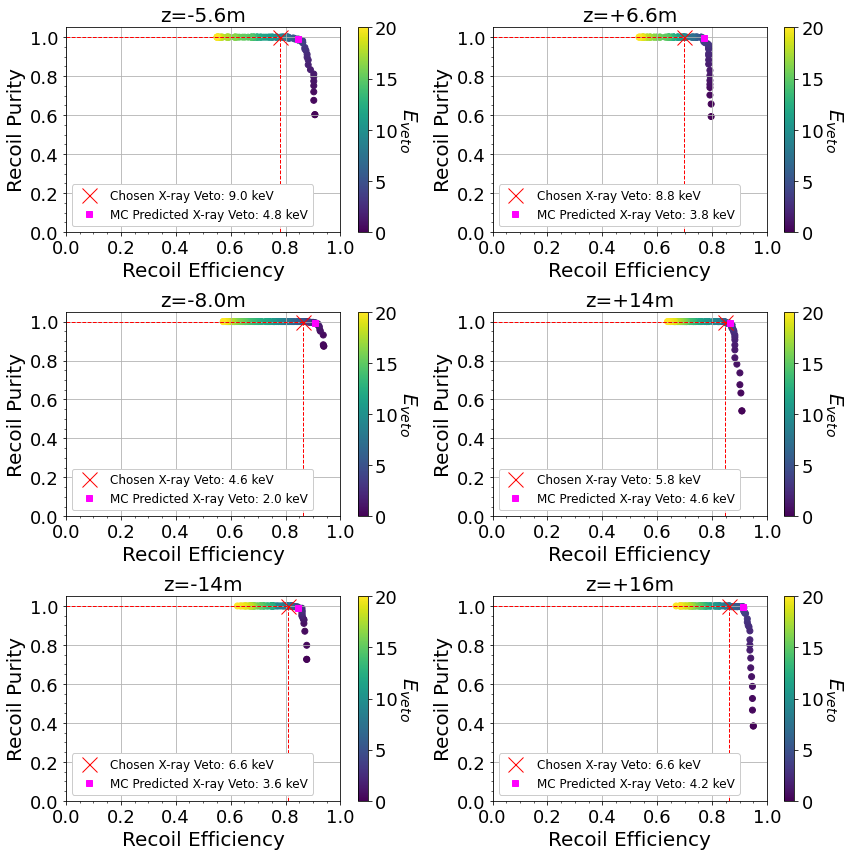

In [62]:

crit = {'palila': 9.0, 'iiwi': 8.8, 'tako': 4.6, 'nene': 5.8, 'elepaio': 6.6, 'humu': 6.6} #actual chosen veto
crit2 = {'palila': 4.8, 'iiwi': 3.8, 'tako': 2.0, 'nene': 4.6, 'elepaio': 3.6, 'humu': 4.2} #MC predicted veto
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (12,12))
i=1
pos = ['z=-5.6m', 'z=+6.6m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1], ax[2,0], ax[2,1]]
for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    df = pd.DataFrame()
    df['E'] = E
    df['purity'] = purity[tpc]
    df['efficiency'] = efficiency[tpc]
    #print(df.loc[np.abs(df['E']-crit[tpc])<0.0001].iloc[0])
    #plt.subplot(3,2,i)
    c=axs[i-1].scatter(efficiency[tpc],purity[tpc],c=E)#,norm=matplotlib.colors.LogNorm(vmin = 1, vmax = 20))
    axs[i-1].plot(df.loc[np.abs(df['E']-crit[tpc])<0.0001]['efficiency'].iloc[0],df.loc[np.abs(df['E']-crit[tpc])<0.0001]['purity'].iloc[0],'x',markersize = 15,color = 'red',label='Chosen X-ray Veto: %s keV'%(round(crit[tpc],2)))
    axs[i-1].plot(df.loc[np.abs(df['E']-crit2[tpc])<0.0001]['efficiency'].iloc[0],df.loc[np.abs(df['E']-crit2[tpc])<0.0001]['purity'].iloc[0],'s',markersize = 6,color = 'magenta',label='MC Predicted X-ray Veto: %s keV'%(round(crit2[tpc],2)))
    axs[i-1].hlines(df.loc[np.abs(df['E']-crit[tpc])<0.0001]['purity'].iloc[0], 0,df.loc[np.abs(df['E']-crit[tpc])<0.0001]['efficiency'].iloc[0],linestyle='--',lw = 1, color = 'red') 
    axs[i-1].vlines(df.loc[np.abs(df['E']-crit[tpc])<0.0001]['efficiency'].iloc[0], 0,df.loc[np.abs(df['E']-crit[tpc])<0.0001]['purity'].iloc[0],linestyle='--',lw = 1, color = 'red') 
    plt.colorbar(c,ax=axs[i-1]).set_label(r'$E_{veto}$',rotation=270,labelpad=20)
    axs[i-1].set_xlabel('Recoil Efficiency')
    axs[i-1].set_ylabel('Recoil Purity')
    axs[i-1].set_xlim(0,1)
    axs[i-1].set_ylim(0,1.05)
    axs[i-1].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    axs[i-1].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i-1].yaxis.set_minor_locator(AutoMinorLocator())
    axs[i-1].set_title(pos[i-1])
    axs[i-1].legend(loc='lower left', framealpha = 1)
    axs[i-1].grid()
    i+=1
plt.tight_layout()
plt.show()

## Summary of xray veto choice

1. We start by finding the lowest xray veto energy where truth MC purity = 1 
2. We then test these xray veto thresholds in data by measuring the percentage of events below threshold leaking into the region above, assuming gaussian energy distributions among particles below energy threshold
3. We set the vet threshold to be the lowest energy with truth MC purity of 1 and leakages <1% in data

Values chosen:
'palila': 9.0, 
'iiwi': 8.8, 
'tako': 4.6, 
'nene': 5.8, 
'elepaio': 6.6, 
'humu': 6.6

### Come up with data/MC systematic
Do it brute force: Inefficient and slow, but it works for now

In [11]:
thresh_errs = {}
for tpc in tpcs:
    thresh_errs[tpc] = data[tpc]['track_energy_err'].iloc[0]/data[tpc]['track_energy'].iloc[0]*crit[tpc]


In [12]:
-thresh_errs['iiwi']

-0.15991663006860043

In [22]:
datamc = {}
datamc_low = {}
datamc_high = {}
indices = [2,3,1,4,0,5]
i=0
for tpc in tpcs:
    datamc[tpc] = a.compute_data_MC_ratios('Cont_inj', E_cut=crit[tpc])[2]
    datamc_high[tpc] = a.compute_data_MC_ratios('Cont_inj',E_cut=crit[tpc], E_cut_err = thresh_errs[tpc])[2]
    datamc_low[tpc] = a.compute_data_MC_ratios('Cont_inj',E_cut=crit[tpc], E_cut_err = -thresh_errs[tpc])[2]
    datamc[tpc] = pd.DataFrame(datamc[tpc].iloc[indices[i]])
    datamc_low[tpc] = pd.DataFrame(datamc_low[tpc].iloc[indices[i]])
    datamc_high[tpc] = pd.DataFrame(datamc_high[tpc].iloc[indices[i]])
    
    i+=1

 FCN=107.985 FROM MINOS     STATUS=SUCCESSFUL    117 CALLS         645 TOTAL
                     EDM=1.48958e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.00000e-05   9.70800e-06  -1.00637e-04** at limit **
   2  p1           7.22145e-15   1.03483e-06   5.47894e-05** at limit **
   3  p2           7.05614e-02   2.66581e-03   2.66581e-03  -2.69380e-04
 FCN=129.221 FROM MINOS     STATUS=SUCCESSFUL    165 CALLS         914 TOTAL
                     EDM=1.57123e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.00000e-05   9.71668e-06   9.38523e-04** at limit **
   2  p1           1.22429e-12   2.55143e-06   6.42784e-06** at limit **
   3  p2           1.10018e-01   

Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in

Turn ratios into single dataframe for convenience

In [24]:
datamc = pd.concat([datamc[val] for val in datamc.keys()], ignore_index = False, axis = 1)
datamc_low = pd.concat([datamc_low[val] for val in datamc_low.keys()], ignore_index = False, axis = 1)
datamc_high = pd.concat([datamc_high[val] for val in datamc_high.keys()], ignore_index = False, axis = 1)

In [25]:
datamc-datamc_low

,palila,iiwi,tako,nene,elepaio,humu
LER_bg_base,0.0,0.0,0.000000,0.000000,0.0,0.000000
LER_bg_base_err,0.0,0.0,0.000000,0.000000,0.0,0.000000
LER_bg_dynamic,0.0,0.0,0.000000,3.315154,0.0,0.000000
LER_bg_dynamic_err,0.0,0.0,0.000000,444.418425,0.0,0.000000
LER_T,NaN,0.0,NaN,0.000000,NaN,0.034046
LER_T_err,NaN,0.0,NaN,0.000000,NaN,0.007599
HER_bg_base,0.0,0.0,0.000000,0.000000,0.0,0.000000
HER_bg_base_err,0.0,0.0,0.000000,0.000000,0.0,0.000000
HER_bg_dynamic,0.0,0.0,0.000000,0.000000,0.0,0.000000
HER_bg_dynamic_err,0.0,0.0,0.000000,0.000000,0.0,0.000000


### Look at data/MC vs E_thresh

In [21]:
rat = {}
rat_err = {}
rat_LER = {}
rat_LER_err = {}
rat_HER = {}
rat_HER_err = {}

Ens = [4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
tpcs = ['elepaio','tako','palila','iiwi','nene','humu']
for tpc in tpcs:
    rat[tpc] = []
    rat_err[tpc] = []
    rat_LER[tpc] = []
    rat_LER_err[tpc] = []
    rat_HER[tpc] = []
    rat_HER_err[tpc] = []
for E in Ens:
    data_MC = a.compute_data_MC_ratios("Cont_inj", E_cut=E)[2]
    i = 0
    for tpc in tpcs:
        rat[tpc].append(data_MC.iloc[i]['Lumi'])
        rat_err[tpc].append(data_MC.iloc[i]['Lumi_err'])
        rat_LER[tpc].append(data_MC.iloc[i]['LER_T'])
        rat_LER_err[tpc].append(data_MC.iloc[i]['LER_T_err'])
        rat_HER[tpc].append(data_MC.iloc[i]['HER_T'])
        rat_HER_err[tpc].append(data_MC.iloc[i]['HER_T_err'])
        i+=1

 FCN=353.686 FROM MINOS     STATUS=SUCCESSFUL     35 CALLS         318 TOTAL
                     EDM=8.2911e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.00000e-05   9.99499e-06  -2.14730e-03** at limit **
   2  p1           1.30025e-06   6.18553e-07   1.07486e-05  -3.92951e-01
   3  p2           2.47134e-01   1.95549e-02   1.95549e-02   8.41711e-04
 FCN=129.292 FROM MINOS     STATUS=SUCCESSFUL    201 CALLS         766 TOTAL
                     EDM=1.0726e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.00000e-05   9.71863e-06   6.39036e-03** at limit **
   2  p1           2.54361e-08   1.62498e-06   4.70129e-06  -1.74618e-01
   3  p2           1.09825e-01   1.

Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in

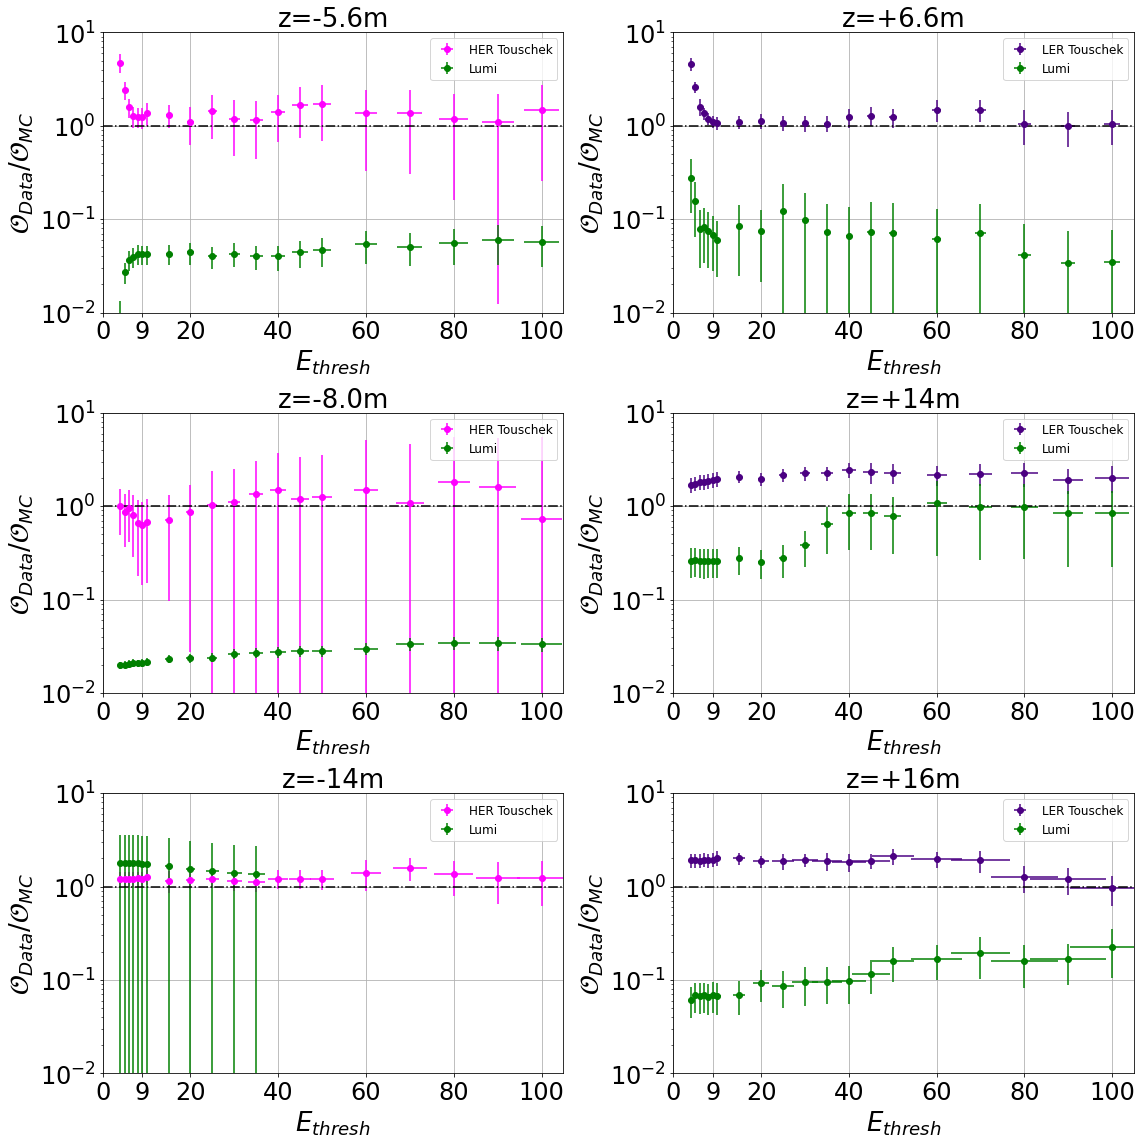

In [23]:
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)

plt.figure(figsize = (16,16))
tpcs = ['palila','iiwi','tako','nene','elepaio','humu']
pos = ['z=-5.6m', 'z=+6.6m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
#pos = ['z=-14m', 'z=-+16m', 'z=+6.6m', 'z=+14m', 'z=-5.6m', 'z=-8.0m']
i=1
for tpc in tpcs:
    plt.subplot(3,2,i)
    if tpc == 'iiwi' or tpc == 'nene' or tpc == 'humu':
        plt.errorbar(Ens,rat_LER[tpc],rat_LER_err[tpc],(Lumi[tpc]['track_energy_err']/Lumi[tpc]['track_energy'])[0]*np.array(Ens),'o', label = 'LER Touschek', color = 'indigo')
    if tpc == 'elepaio' or tpc == 'palila' or tpc == 'tako':
        plt.errorbar(Ens,rat_HER[tpc],rat_HER_err[tpc],(Lumi[tpc]['track_energy_err']/Lumi[tpc]['track_energy'])[0]*np.array(Ens),'o', label = 'HER Touschek', color = 'magenta')
    plt.errorbar(Ens,rat[tpc],rat_err[tpc],(Lumi[tpc]['track_energy_err']/Lumi[tpc]['track_energy'])[0]*np.array(Ens),'o', label = 'Lumi', color = 'green')
    plt.ylabel(r'$\mathcal{O}_{Data}/\mathcal{O}_{MC}$')
    plt.xlabel(r'$E_{thresh}$')
    plt.hlines(1,0,105, color = 'k', linestyle = '-.')
    plt.title(pos[i-1])
    #try:
    #    ymax = (np.array(rat[tpc])+1.1*np.array(rat_err[tpc])).max()
    #    #ymax = .0005
    #    plt.ylim(0,ymax)
    #except ValueError:
    #    ymax = 2
    #    plt.ylim(0,ymax)
    plt.ylim(0.01,10)
    plt.yscale("log")
    plt.xlim(0,105)
    plt.xticks([0,9,20,40,60,80,100])
    #plt.yticks([-1,-0.5,0,0.5,1,1.5,2,2.5,3])
    plt.grid(which = 'major')
    i+=1
    plt.legend()
plt.tight_layout()
plt.show()

### Visualize MC events on VRC
Not important to show here, was used in a different notebook to test this feature

In [ ]:
def plot_event_and_vrc(df, i, color = 'cyan'):
    plt.figure(figsize = (10,8))
    e,f,g,h = plt.hist2d(df['column'].iloc[i], df['row'].iloc[i], weights = df['tot'].iloc[i], bins = [80*3,336*3], range = [(-79,159),(-335,670)], vmin = 0, vmax = 12)
    plt.colorbar(h).set_label('ToT', rotation = 270, labelpad = 20)
    plt.vlines(-79, -670, 670, color = color)
    plt.vlines(0, -670, 670, color = color)
    plt.vlines(79, -670, 670, color = color)
    plt.hlines(-335, -159, 159, color = color)
    plt.hlines(0, -159, 159, color = color)
    plt.hlines(335, -159, 159, color = color)
plot_event_and_vrc(MC['palila'].loc[(MC['palila']['bgType']=='RBB_Lumi')&(MC['palila']['VRC_id']==9)],2)

In [ ]:
def plot_event(df, i, color = 'cyan'):
    e,f,g,h = plt.hist2d(df['column'].iloc[i], df['row'].iloc[i], weights = df['tot'].iloc[i], bins = [80,336], range = [(0,79),(0,335)], vmin = 0, vmax = 12,cmap ='viridis')
    plt.colorbar(h).set_label('TOT', rotation = 270, labelpad = 20)
    #plt.vlines(-79, -670, 670, color = color)
    #plt.vlines(0, -670, 670, color = color)
    #plt.vlines(79, -670, 670, color = color)
    #plt.hlines(-335, -159, 159, color = color)
    #plt.hlines(0, -159, 159, color = color)
    #plt.hlines(335, -159, 159, color = color)
    plt.xlabel('Column')
    plt.ylabel('Row')
fig = plt.figure(figsize = (10,6))
plot_event(Lumi['elepaio'].loc[Lumi['elepaio']['is_recoil']==1],11)
#plt.ylim(0,150)

In [ ]:
Lumi['elepaio'].columns

# Start Angular Analysis

### Find optimal chi2 for energy

palila 0 keV  175.57797632182735 28710events. Theta p-value = 1.4308549680672206e-139 phi p-val =  4.242122144582979e-33
tako 2 keV  137.78064812299763 10871events. Theta p-value = 2.3454379473000556e-61 phi p-val =  2.9615717055490515e-25
elepaio 0 keV  107.95693403888525 8658events. Theta p-value = 3.8292987744393697e-19 phi p-val =  2.7337251516767904e-20
iiwi 0 keV  90.99779076259699 58873events. Theta p-value = 0.0 phi p-val =  1.02655624278977e-15
nene 0 keV  113.00249692254458 11420events. Theta p-value = 9.864771149780699e-78 phi p-val =  3.5944308469884646e-20
humu 0 keV  36.83388953402808 1746events. Theta p-value = 2.8176417969167363e-05 phi p-val =  1.035821833233872e-07


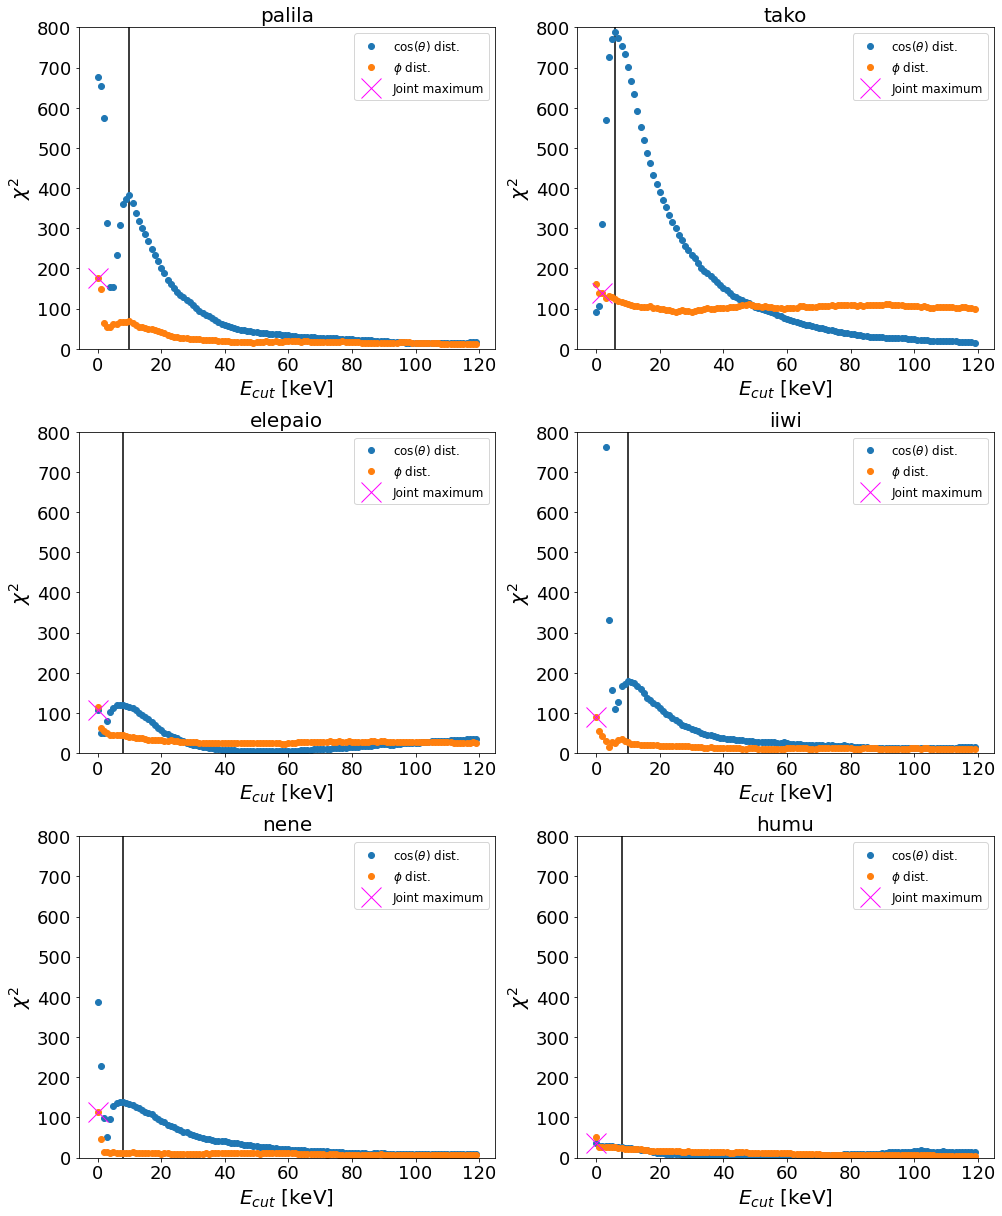

Warning in <TH1D::Chi2TestX>: Both histograms are not unweighted and option UU has been requested
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TH1D::Chi2TestX>: Both histograms are not unweighted and option UU has been requested
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TH1D::Chi2TestX>: Both histograms are not unweighted and option UU has been requested
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TH1D::Chi2TestX>: Both histograms are not unweighted and option UU has been requested
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing T

In [63]:
import array

def perform_chi2_vs_uniform(data,E_cut,xmin = -1, xmax = 1, nbins = 11, angle = 'theta'):
    data['ones'] = 1
    data = data.loc[data['track_energy']>E_cut]
    if angle == 'theta':
        group = data.groupby(pd.cut(np.cos(data['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    else:
        xmin = -np.pi/2
        xmax = np.pi/2
        group = data.groupby(pd.cut((data['new_phi']), bins = np.linspace(xmin,xmax,nbins))).sum()
    chi2 = array.array('d', [0])
    ndf = array.array('i', [0])
    igood = array.array('i', [0])
    option = "UU P"
    n=len(group)
    res = array.array('d', [0 for i in range(0,n)])
    num = group['ones']
    error = 1/np.sqrt(group['ones'])
    h1 = ROOT.TH1D("h1", "h1", nbins, xmin, xmax)
    h2 = ROOT.TH1D("h2", "h2", nbins, xmin, xmax)
    for i in range(0,n):
        h1.SetBinContent(i+1,num.fillna(0)[i])
        h1.SetBinError(i+1,error.fillna(0)[i])
        h2.SetBinContent(i+1,num.sum()/n)
        #h2.SetBinError(i+1,num.fillna(0)[i]*np.sqrt((xmax-xmin)**2/12)/(n*np.sqrt(n)))
    val = h1.Chi2TestX(h2, chi2, ndf, igood, option, res=res)
    return h1, h2, chi2[0], len(data), val


plt.figure(figsize = (14,17))
i=1
tpcs = ['palila','tako','elepaio','iiwi','nene','humu']
vals = [10, 6,8,10,8,8]
for tpc in tpcs:
    theta_chi2 = []
    phi_chi2 = []
    theta_pvals = []
    phi_pvals = []
    energies = []
    num_events = []
    for E in range(0,120):
        h1,h2,val_theta, events, theta_pval = perform_chi2_vs_uniform(Lumi[tpc], E, angle = 'theta')
        h1,h2,val_phi, events, phi_pval = perform_chi2_vs_uniform(Lumi[tpc], E, angle = 'phi')
        theta_chi2.append(val_theta)
        phi_chi2.append(val_phi)
        energies.append(E)
        num_events.append(events)
        theta_pvals.append(theta_pval)
        phi_pvals.append(phi_pval)

    plt.subplot(3,2,i)
    df = pd.DataFrame()
    df['E']= energies
    df['theta_chi2'] = theta_chi2
    df['phi_chi2'] = phi_chi2
    df['theta_pval'] = theta_pvals
    df['phi_pval'] = phi_pvals
    df['events'] = num_events
    chi2s = df[['theta_chi2','phi_chi2']].to_numpy()
    min_chi2 = [np.min(chi2s[i]) for i in range(0,len(chi2s))]
    df['min_chi2'] = min_chi2
    plt.plot(df['E'],df['theta_chi2'],'o', label = r'$\cos(\theta)$ dist.')
    plt.plot(df['E'],df['phi_chi2'],'o', label = r'$\phi$ dist.')
    crit = df.loc[df['min_chi2']==df['min_chi2'].max()]
    print(tpc + ' ' + str(crit['E'].iloc[0]) + ' keV  ' + str(crit['min_chi2'].iloc[0]) + ' ' + str(crit['events'].iloc[0]) + 'events. Theta p-value = ' + str(crit['theta_pval'].iloc[0]) + ' phi p-val = ', str(crit['phi_pval'].iloc[0]))
    plt.plot(crit['E'],crit['min_chi2'],'x', label = r'Joint maximum', markersize = 20, color = 'magenta')
    plt.vlines(vals[i-1],0,800,color = 'k')
    plt.xlabel(r'$E_{cut}$ [keV]')
    plt.ylabel(r'$\chi^2$')
    plt.ylim(0,800)
    plt.title(tpc)
    plt.legend()
    i+=1
plt.tight_layout()
plt.show()

### 2D histogram to check energy peak

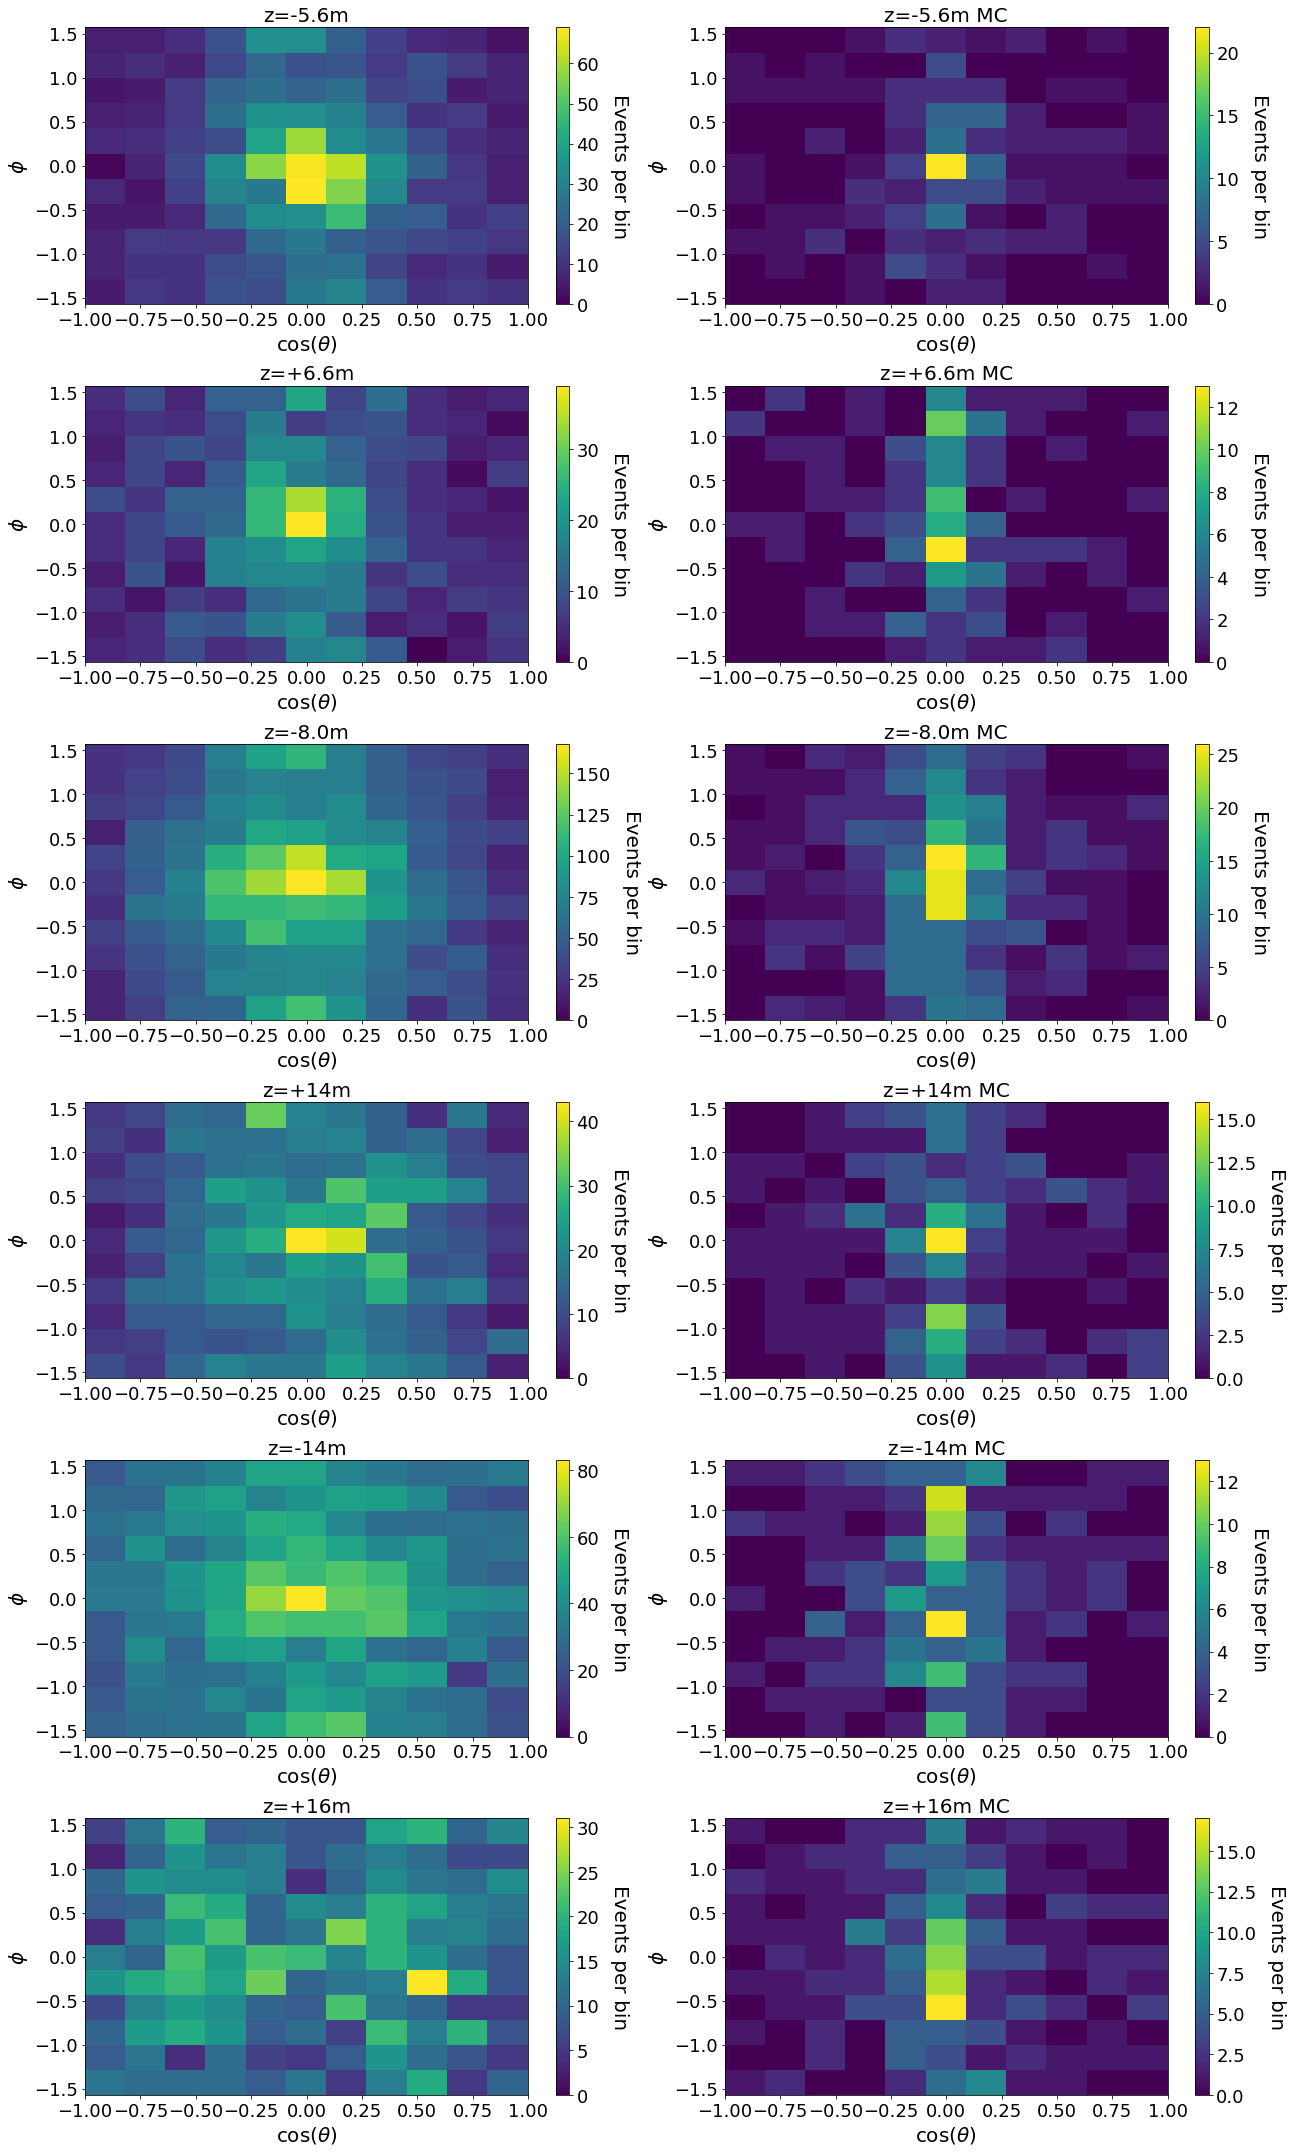

In [64]:
tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
pos = ['z=-5.6m', 'z=+6.6m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
j=1
i=1
plt.figure(figsize = (18,30))
E_cut = {'palila': 10,'iiwi': 10,'tako': 6,'nene': 8,'elepaio': 8,'humu': 8}
for tpc in tpcs:
    plt.subplot(6,2,i)
    z,y,x,w = plt.hist2d(np.cos(Lumi[tpc].loc[Lumi[tpc]['track_energy']>=E_cut[tpc]]['new_theta']), Lumi[tpc].loc[Lumi[tpc]['track_energy']>=E_cut[tpc]]['new_phi'], range = ((-1,1),(-np.pi/2,np.pi/2)), bins = (11, 11),vmin = 0)#, weights = Lumi[tpc]['track_energy'])
    plt.title(pos[j-1])
    plt.xlabel(r'$\cos(\theta)$')
    plt.ylabel(r'$\phi$')
    #plt.colorbar(d).set_label(r'$\sum E$ per bin [keV]', rotation = 270, labelpad = 30)
    plt.colorbar(w).set_label(r'Events per bin', rotation = 270, labelpad = 30)
    plt.subplot(6,2,i+1)
    z,y,x,w = plt.hist2d(np.cos(MC[tpc].loc[MC[tpc]['reco_energy']>=E_cut[tpc]]['new_theta']), MC[tpc].loc[MC[tpc]['reco_energy']>=E_cut[tpc]]['new_phi'], range = ((-1,1),(-np.pi/2,np.pi/2)), bins = (11, 11))#, weights = MC[tpc]['reco_energy'])
    plt.title(pos[j-1] + ' MC')
    plt.xlabel(r'$\cos(\theta)$')
    plt.ylabel(r'$\phi$')
    plt.colorbar(w).set_label(r'Events per bin', rotation = 270, labelpad = 30)
    j+=1
    i+=2
plt.tight_layout()
plt.show()

# Scale MC to study time of 1s

In [65]:
min_Lumi = 1e11
max_Lumi = 0
min_LER = 1e11
max_LER = 0
min_HER = 1e11
max_HER = 0

tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']

for tpc in tpcs:
    lumi = Lumi[tpc]['timestamp_start'].to_numpy()
    ler = LER[tpc]['timestamp_start'].to_numpy()
    her = HER[tpc]['timestamp_start'].to_numpy()
    for val in lumi:
        if val < min_Lumi:
            min_Lumi = val
        if val > max_Lumi:
            max_Lumi = val
    for val in ler:
        if val < min_LER:
            min_LER = val
        if val > max_LER:
            max_LER = val
    for val in her:
        if val < min_HER:
            min_HER = val
        if val > max_HER:
            max_HER = val

dt_Lumi = max_Lumi-min_Lumi
dt_HER = max_HER-min_HER
dt_LER = max_LER-min_LER
scale_HER = dt_HER/dt_Lumi
scale_LER = dt_LER/dt_Lumi
print(scale_HER, scale_LER)


2.078550838287411 1.0400464670293277


In [66]:
skb = a.select_study("Lumi", "Cont_inj")
Scaled_MC = {}
tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
factors = {'Coulomb_LER_base' : 1/4., 'Coulomb_LER_dynamic' : 1/4., 
           'Coulomb_HER_base' : 1/40., 'Coulomb_HER_dynamic' : 1/40.,
          'Brems_LER_base' : 1/40., 'Brems_LER_dynamic' : 1/40., 
           'Brems_HER_base' : 1/400., 'Brems_HER_dynamic' : 1/400.,
          'Touschek_LER_all' : 2.5, 'Touschek_HER_all' : 0.625,
          'RBB_Lumi' : (skb['ECL_lumi'].mean()/10000)/(25*1e-3), 'twoPhoton_Lumi' : 100*(skb['ECL_lumi'].mean()/10000)/25.}
for tpc in tpcs:
    Scaled_MC[tpc] = MC[tpc].loc[MC[tpc]['VRC_id']>0][['reco_energy','new_theta', 'new_phi','bgType', 'VRC_id']]
    Scaled_MC[tpc].index = [i for i in range(0,len(Scaled_MC[tpc]))]
    Scaled_MC[tpc]['ones'] = 1
    Scaled_MC[tpc]['scaled_energy'] = 0
    Scaled_MC[tpc]['weights'] = 1
for tpc in tpcs:
    for key in factors.keys():
        index = Scaled_MC[tpc].loc[(Scaled_MC[tpc]['bgType'] == key)].index.to_numpy()
        for val in index:
            if (key == 'Coulomb_LER_base') or (key == 'Brems_LER_base'):
                wkey = 'LER_bg_base'
            elif (key == 'Coulomb_HER_base') or (key == 'Brems_HER_base'):
                wkey = 'HER_bg_base'
            elif (key == 'Coulomb_LER_dynamic') or (key == 'Brems_LER_dynamic'):
                wkey = 'LER_bg_dynamic'
            elif (key == 'Coulomb_HER_dynamic') or (key == 'Brems_HER_dynamic'):
                wkey = 'HER_bg_dynamic'
            elif key == 'Touschek_LER_all':
                wkey = 'LER_T'
            elif key == 'Touschek_HER_all':
                wkey = 'HER_T'
            else:
                wkey = 'Lumi'
            Scaled_MC[tpc]['weights'].iloc[val] = factors[key]*(datamc.T.loc[data_MC.index == tpc])[wkey][0]
            #Scaled_MC[tpc]['reco_energy'].iloc[val] = factors[key]*Scaled_MC[tpc]['reco_energy'].iloc[val]
            #Scaled_MC[tpc]['scaled_energy'].iloc[val] = factors[key]*Scaled_MC[tpc]['reco_energy'].iloc[val]
            Scaled_MC[tpc]['scaled_energy'].iloc[val] = Scaled_MC[tpc]['weights'].iloc[val]*Scaled_MC[tpc]['reco_energy'].iloc[val]

### Angular dist plot without energy weights

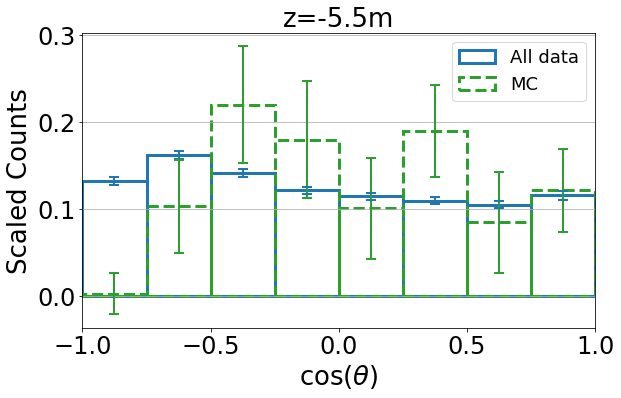

In [222]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 9
xmin = -1
xmax = 1
phi_low = -np.pi/2
phi_high = np.pi/2
#E_cut = {'palila': 20,'tako': 20,'elepaio': 20,'iiwi': 10,'nene': 8,'humu': 8}
E_cut = {'palila': 40, 'tako': 46, 'elepaio': 20, 'iiwi': 60, 'nene': 40, 'humu': 82}
width = (np.abs(xmin)+np.abs(xmax))/(nbins-1)
center = [xmin +(width*i)+width/2 for i in range(0,nbins-1)]
#tpcs = ['palila','iiwi','tako','nene', 'elepaio','humu']
#pos = ['z=-5.5m', 'z=+6.5', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']#
#tpcs = ['iiwi', 'nene', 'humu']
#pos = ['z=+6.5m', 'z=+14m', 'z=+16m']
tpcs = ['humu']
pos = ['z=-5.5m']
plt.figure(figsize = (16,15))
i=1
j=1
for tpc in tpcs:
    data[tpc]['ones'] = 1
    Lumi[tpc]['ones'] = 1
    Single_beam[tpc]['ones'] = 1
    HER[tpc]['ones'] = 1
    LER[tpc]['ones'] = 1
    #Scaled_MC[tpc]['counts'] = 1
    
    ### CUTS ###
    data_tmp = data[tpc].loc[(np.abs(data[tpc]['new_phi'])<phi_high) & (np.abs(data[tpc]['new_phi'])>phi_low)]
    Lumi_tmp = Lumi[tpc].loc[(np.abs(Lumi[tpc]['new_phi'])<phi_high) & (np.abs(Lumi[tpc]['new_phi'])>phi_low)]
    MC_tmp = Scaled_MC[tpc].loc[(np.abs(Scaled_MC[tpc]['new_phi'])<phi_high) & (np.abs(Scaled_MC[tpc]['new_phi'])>phi_low)]
    MC_tmp2 = MC_tmp.loc[MC_tmp['VRC_id']==5]
    MC_tmp2.index = [i for i in range(0,len(MC_tmp2))]
    SB_tmp = Single_beam[tpc].loc[(np.abs(Single_beam[tpc]['new_phi'])<phi_high) & (np.abs(Single_beam[tpc]['new_phi'])>phi_low)]
    HER_tmp = HER[tpc].loc[(np.abs(HER[tpc]['new_phi'])<phi_high) & (np.abs(HER[tpc]['new_phi'])>phi_low)]
    LER_tmp = LER[tpc].loc[(np.abs(LER[tpc]['new_phi'])<phi_high) & (np.abs(LER[tpc]['new_phi'])>phi_low)]
    
    data_tmp = data_tmp.loc[data_tmp['track_energy']>E_cut[tpc]]
    Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>E_cut[tpc]]
    MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>E_cut[tpc]]
    MC_tmp2 = MC_tmp2.loc[MC_tmp2['reco_energy']>E_cut[tpc]] #no lumi
    MC_tmp3 = MC_tmp.loc[MC_tmp['reco_energy']>E_cut[tpc]] #hotspots
    SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>E_cut[tpc]]
    HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>E_cut[tpc]]
    LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>E_cut[tpc]]
    
    ############
    
    #MC_tmp2 = MC_tmp2.loc[(MC_tmp2['bgType'] != 'twoPhoton_Lumi') & (MC_tmp2['bgType'] != 'RBB_Lumi')]
    #MC_tmp2.index = [i for i in range(0,len(MC_tmp2))]
    
    
    test = Lumi_tmp.groupby(pd.cut(np.cos(Lumi_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_all = data_tmp.groupby(pd.cut(np.cos(data_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_MC = MC_tmp.groupby(pd.cut(np.cos(MC_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_MC2 = MC_tmp2.groupby(pd.cut(np.cos(MC_tmp2['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_SB = SB_tmp.groupby(pd.cut(np.cos(SB_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_HER = HER_tmp.groupby(pd.cut(np.cos(HER_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_LER = LER_tmp.groupby(pd.cut(np.cos(LER_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    
    #test = Lumi_tmp.groupby(pd.cut(Lumi_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_MC = MC_tmp.groupby(pd.cut(MC_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_MC2 = MC_tmp2.groupby(pd.cut(MC_tmp2['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_MC3 = MC_tmp3.groupby(pd.cut(MC_tmp3['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_SB = SB_tmp.groupby(pd.cut(SB_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_HER = HER_tmp.groupby(pd.cut(HER_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_LER = LER_tmp.groupby(pd.cut(LER_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    
    
    plt.subplot(3,2,i)
    
    #plot 0: all data
    n0 = (test_all['ones'])
    d0 = (test_all['ones']).sum()
    err0 = 1/d0*np.sqrt(test['ones'])
    #p1 = plt.bar(center,n1 ,yerr = err1*d1, width = width, label = 'Data', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    p0 = plt.bar(center,n0/d0 ,yerr = err0, width = width, label = 'All data', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
  
    #plot 1: Collisions
    n1 = (test['ones'])
    d1 = (test['ones']).sum()
    err1 = 1/d1*np.sqrt(test['ones'])
    #p1 = plt.bar(center,n1 ,yerr = err1*d1, width = width, label = 'Data', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    #p1 = plt.bar(center,n1/d1 ,yerr = err1, width = width, label = 'Collisions', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
  
    #Plot 2: Single beam
    n2 = (scale_HER*test_HER['ones']+scale_LER*test_LER['ones'])
    d2 = (scale_HER*test_HER['ones']+scale_LER*test_LER['ones']).sum()
    err2 = 1/d2*np.sqrt(test_HER['ones'] + test_LER['ones'])
    #p2 = plt.bar(center,n2*500/1e6,yerr=err2*d2*500/1e6,width = width, label = '500*Single beam data', fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    #p2 = plt.bar(center,n2/d2,yerr=err2,width = width, label = 'No collisions', fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    
    #Plot 3: All MC to be compared with collisions EXPANDED CHIP AREA
    n3 = (test_MC['ones']*(test_MC['scaled_energy']/test_MC['reco_energy']))
    d3 = (test_MC['ones']*(test_MC['scaled_energy']/test_MC['reco_energy'])).sum()
    err3 = 1/d3*np.sqrt(test_MC['ones']*(test_MC['scaled_energy']**2/test_MC['reco_energy']**2).mean())
    #n3 = (test_MC['ones'])
    #d3 = (test_MC['ones']).sum()
    #err3 = 1/d3*np.sqrt(test_MC['ones'])
    #p3 = plt.bar(center,n3*len(study_period)/100,yerr=err3*d3*len(study_period)/100,width = width, label = 'MC', fc = 'None', ec = 'lime',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='lime', lw=2, capsize=5, capthick=2))
    #p3 = plt.bar(center,n3/d3,yerr=err3,width = width, label = 'MC expanded chip', fc = 'None', ec = 'tab:red',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:red', lw=2, capsize=5, capthick=2))
    
    #Plot 4: All MC to be compared with collisions ACTUAL CHIP AREA
    n4 = (test_MC2['ones']*(test_MC2['scaled_energy']/test_MC2['reco_energy']))
    d4 = (test_MC2['ones']*(test_MC2['scaled_energy']/test_MC2['reco_energy'])).sum()
    err4 = 1/d4*np.sqrt(test_MC2['ones']*(test_MC2['scaled_energy']**2/test_MC2['reco_energy']**2).mean())
    #n4 = (test_MC2['ones'])
    #d4 = (test_MC2['ones']).sum()
    #err4 = 1/d4*np.sqrt(test_MC2['ones'])
    #p3 = plt.bar(center,n3*len(study_period)/100,yerr=err3*d3*len(study_period)/100,width = width, label = 'MC', fc = 'None', ec = 'lime',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='lime', lw=2, capsize=5, capthick=2))
    p4 = plt.bar(center,n4/d4,yerr=err4,width = width, label = 'MC', fc = 'None', ec = 'tab:green',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    #plt.hlines(0,0,1,color = 'k')
    plt.ylabel(r'Scaled Counts')
    #plt.ylabel('Scaled Counts')
    plt.xlabel(r'$\cos(\theta)$')
    plt.xlim(xmin,xmax)
    #plt.ylim(-0.03,0.35)
    plt.title(pos[j-1])
    plt.legend(handles = [p0,p4],ncol=1)
    plt.grid(axis='y')
    
    j+=1
    i+=1
plt.tight_layout()
#plt.savefig("angular_distribution.jpg")
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)

In [218]:
import array
def perform_root_chi2_test(data1,data2,err1,err2,xmin = xmin, xmax = xmax):
    n = len(data1)
    res = array.array('d', [0 for i in range(0,n)])
    chi2 = array.array('d', [0])
    ndf = array.array('i', [0])
    igood = array.array('i', [0])
    option = "WW P"
    h1 = ROOT.TH1D("h1", "h1", n, xmin, xmax)
    h2 = ROOT.TH1D("h2", "h2", n, xmin, xmax)
    for i in range(0,len(data1)):
        h1.SetBinContent(i+1,data1.fillna(0)[i])
        h1.SetBinError(i+1,err1.fillna(0)[i])
        h2.SetBinContent(i+1,data2.fillna(0)[i])
        h2.SetBinError(i+1,err2.fillna(0)[i])
    test = h1.Chi2TestX(h2, chi2, ndf, igood, option, res=res)
    return h1, h2, chi2, test
h1,h2,res,p = perform_root_chi2_test(n1/d1,n4/d4,err1,err4)


Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 10 effective events.



In [219]:
p

1.6809824174048754e-14

In [ ]:
c1 = ROOT.TCanvas("c1","c1",800,600)
f = ROOT.TF1("f","TMath::Gaus(x,0,1)",-10,10)
qqplot = ROOT.TGraphQQ(len(n1),res,f)
qqplot.SetMarkerStyle(20)
qqplot.SetMarkerColor(2)
qqplot.SetMarkerSize(.9)
qqplot.SetTitle("Q-Q plot of Normalized Residuals")
qqplot.Draw("AP")
c1.Draw()

In [ ]:
def perform_chi2_vs_uniform(data,err,xmin = xmin, xmax = xmax):
    n = len(data)
    h1 = ROOT.TH1D("h1", "h1", n, xmin, xmax)
    h2 = ROOT.TH1D("h2", "h2", n, xmin, xmax)
    for i in range(0,len(data)):
        h1.SetBinContent(i+1,data[i])
        h1.SetBinError(i+1,err.fillna(0)[i])
        h2.SetBinContent(i+1,1/n)
        h2.SetBinError(i+1,np.sqrt((xmax-xmin)**2/12)/(n*np.sqrt(n)))
    val = h1.Chi2Test(h2,"WW P")
    return h1, h2, val
h1,h2,val = perform_chi2_vs_uniform(n1/d1,err1)

In [ ]:
def compute_test_statistic(n1,n2,d1=1,d2=1):
    return np.sum((n1/d1-n2/d2)**2/(n1/d1**2+n2/d2**2))
compute_test_statistic(n1,n5,d1,d5)

In [ ]:
from scipy import stats
stats.ks_2samp(, n4)


In [ ]:
c1 = ROOT.TCanvas("c1","c1",800,600)
h1.Draw()
h2.Draw('SAME')
c1.Draw()

In [ ]:
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=22)
plt.rc('axes', titlesize=22)
plt.figure(figsize = (20,25))
i = 1
j=1
pos = ['z=16m', 'z=14m', 'z=6.5m', 'z=-5.5m', 'z=-8.0m', 'z=-14m']
for tpc in ['humu', 'nene', 'iiwi', 'palila', 'tako', 'elepaio']:
    plt.subplot(6,3,i+1)
    a1,b1,c1,d1 = plt.hist2d(Lumi[tpc]['new_theta'], Lumi[tpc]['new_phi'], bins=(11,11), range=((0,np.pi),(0,np.pi)), density=None, vmin = 0, weights=Lumi[tpc]['track_energy']/Lumi[tpc]['track_energy'].sum())
    plt.colorbar(d1).set_label(r'$\Sigma E$ per bin [keV]', rotation = 270, labelpad = 20)
    plt.title('Lumi ' + pos[j-1])
    #plt.yticks([-90,-60,-30,0,30,60,90])
    plt.ylabel(r'$\phi[^\circ]$')
    plt.xlabel(r'$|\cos(\theta)|$')
    plt.subplot(6,3,i)
    a2,b2,c2,d2 = plt.hist2d(Single_beam[tpc]['new_theta'], Single_beam[tpc]['new_phi'], bins=(11,11), range=((0,np.pi),(0,np.pi)), density=None, vmin = 0, weights=Single_beam[tpc]['track_energy']/Single_beam[tpc]['track_energy'].sum())
    plt.colorbar(d2).set_label(r'$\Sigma E$ per bin [keV]', rotation = 270, labelpad = 20)
    plt.title('Single Beam ' + pos[j-1])
    #plt.yticks([-90,-60,-30,0,30,60,90])
    plt.ylabel(r'$\phi[^\circ]$')
    plt.xlabel(r'$|\cos(\theta)|$')
    plt.subplot(6,3,i+2)
    a3,b3,c3,d3 = plt.hist2d(MC[tpc]['new_theta'], MC[tpc]['new_phi'], bins=(11,11), range=((0,np.pi),(0,np.pi)), density=None, vmin = 0, weights=MC[tpc]['reco_energy']/MC[tpc]['reco_energy'].sum())
    plt.colorbar(d2).set_label(r'$\Sigma E$ per bin [keV]', rotation = 270, labelpad = 20)
    plt.title('MC ' + pos[j-1])
    #plt.yticks([-90,-60,-30,0,30,60,90])
    plt.ylabel(r'$\phi[^\circ]$')
    plt.xlabel(r'$|\cos(\theta)|$')
    i+=3
    j+=1
plt.tight_layout()
plt.show()

In [ ]:
tpc = 'tako'
nbins = 21
Lumi_tmp = Lumi[tpc].loc[(np.abs(Lumi[tpc]['new_phi'])<np.pi/6) | (np.abs(Lumi[tpc]['new_phi'])>5*np.pi/6)]
MC_tmp = Scaled_MC[tpc].loc[(np.abs(Scaled_MC[tpc]['new_phi'])<np.pi/6) | (np.abs(Scaled_MC[tpc]['new_phi'])>5*np.pi/6)]
SB_tmp = Single_beam[tpc].loc[(np.abs(Single_beam[tpc]['new_phi'])<np.pi/6) | (np.abs(Single_beam[tpc]['new_phi'])>5*np.pi/6)]
HER_tmp = HER[tpc].loc[(np.abs(HER[tpc]['new_phi'])<np.pi/6) | (np.abs(HER[tpc]['new_phi'])>5*np.pi/6)]
LER_tmp = LER[tpc].loc[(np.abs(LER[tpc]['new_phi'])<np.pi/6) | (np.abs(LER[tpc]['new_phi'])>5*np.pi/6)]
    
Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>0]
MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>0]
MC_tmp2 = MC_tmp.loc[MC_tmp['reco_energy']>0]
MC_tmp3 = MC_tmp.loc[MC_tmp['reco_energy']>0]
SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>0]
HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>0]
LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>0]

MC_tmp2 = MC_tmp2.loc[((MC_tmp2['truth_mother_Z']>-870) & #Line is for RBB hotspot
               (MC_tmp2['truth_mother_Z']<=-750) & (MC_tmp2['truth_mother_X']>20) &
                                       (MC_tmp2['truth_mother_X']<=60) &
                                       (np.abs(MC_tmp2['truth_mother_Y'])<20))
                                      |                                
                                      (MC_tmp2['truth_mother_Z']>1390) &
                                      (MC_tmp2['truth_mother_Z']<=1680) &
                                      (MC_tmp2['truth_mother_X']<80) &
                                      (MC_tmp2['truth_mother_X']>=30) &
                                      (np.abs(MC_tmp2['truth_mother_Y'])<20)] #FWD and BWD hotspots
MC_tmp2.index = [i for i in range(0,len(MC_tmp2))]

MC_tmp3 = MC_tmp3.loc[((MC_tmp3['truth_mother_Z']<=-870) | #Line is for RBB hotspot
               (MC_tmp3['truth_mother_Z']>-750) | (MC_tmp3['truth_mother_X']<=20) |
                                       (MC_tmp3['truth_mother_X']>60) |
                                       (np.abs(MC_tmp3['truth_mother_Y'])>=20))
                                      &                                
                                      (MC_tmp3['truth_mother_Z']<=1390) |
                                      (MC_tmp3['truth_mother_Z']>1680) |
                                      (MC_tmp3['truth_mother_X']>=80) |
                                      (MC_tmp3['truth_mother_X']<30) |
                                      (np.abs(MC_tmp3['truth_mother_Y'])>=20)] #FWD and BWD hotspots

(counts, bins) = np.histogram(Lumi_tmp['new_theta'], bins=nbins, range = (0,np.pi), weights = Lumi_tmp['track_energy'])
factor = 1/(len(Lumi_tmp))
plt.hist(bins[:-1], bins, weights=factor*counts, label = 'Data Lumi', histtype = 'step')
(counts_MC2, bins_MC2) = np.histogram(MC_tmp2['new_theta'], bins=nbins, range = (0,np.pi), weights = MC_tmp2['reco_energy'])
factor_MC2 = 1/(len(MC_tmp2))
plt.hist(bins_MC2[:-1], bins_MC2, weights=factor_MC2*counts_MC2, label = 'MC Hotspot', histtype = 'step')
(counts_MC3, bins_MC3) = np.histogram(MC_tmp3['new_theta'], bins=nbins, range = (0,np.pi), weights = MC_tmp3['reco_energy'])
factor_MC3 = 1/len(MC_tmp3)
plt.hist(bins_MC3[:-1], bins_MC3, weights=factor_MC3*counts_MC3, label = 'MC Not Hotspot', histtype = 'step')
    

#plt.hist(np.cos(Lumi['tako']['new_theta']), bins = 21, range = (-1,1), histtype = 'step')
#plt.hist(np.cos(MC['tako']['new_theta']), bins = 21, range = (-1,1), histtype = 'step')

In [154]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 11
width = 1/(nbins-1)
center = [(width*i)+width/2 for i in range(0,nbins-1)]
#tpcs = ['palila','tako', 'elepaio']
#pos = ['z=-5.5m', 'z=-8.0m', 'z=-14m']#
#tpcs = ['palila', 'iiwi', 'tako']#, 'nene', 'elepaio', 'humu']
#pos = ['z=-5.5m', 'z=+6.5m', 'z=-8.0m']#, 'z=+14m', 'z=-14m', 'z=+16m']
tpcs = ['tako']
pos = ['z=-8.0m']
plt.figure(figsize = (11,8))
i=1
j=1
for tpc in tpcs:
    Lumi[tpc]['ones'] = 1
    Single_beam[tpc]['ones'] = 1
    HER[tpc]['ones'] = 1
    LER[tpc]['ones'] = 1
    Scaled_MC[tpc]['counts'] = 1
    
    ### CUTS ###
    Lumi_tmp = Lumi[tpc].loc[np.abs(Lumi[tpc]['phi_fold'])<30]
    MC_tmp = Scaled_MC[tpc].loc[np.abs(Scaled_MC[tpc]['phi_fold'])<30]
    SB_tmp = Single_beam[tpc].loc[np.abs(Single_beam[tpc]['phi_fold'])<30]
    HER_tmp = HER[tpc].loc[np.abs(HER[tpc]['phi_fold'])<30]
    LER_tmp = LER[tpc].loc[np.abs(LER[tpc]['phi_fold'])<30]
    
    Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>40]
    MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>40]
    MC_tmp2 = MC_tmp.loc[MC_tmp['reco_energy']>40]
    MC_tmp3 = MC_tmp.loc[MC_tmp['reco_energy']>40]
    SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>40]
    HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>40]
    LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>40]
    
    ### We subtract what's below from the total MC sample to get MC from the hotspot
    
    MC_tmp2 = MC_tmp2.loc[((MC_tmp2['truth_mother_Z']<=-870) | #Line is for RBB hotspot
               (MC_tmp2['truth_mother_Z']>-750) | (MC_tmp2['truth_mother_X']<=20) |
                                       (MC_tmp2['truth_mother_X']>60) |
                                       (np.abs(MC_tmp2['truth_mother_Y'])>=20))
                                      &                                
                                      (MC_tmp2['truth_mother_Z']<=1390) |
                                      (MC_tmp2['truth_mother_Z']>1680) |
                                      (MC_tmp2['truth_mother_X']>=80) |
                                      (MC_tmp2['truth_mother_X']<30) |
                                      (np.abs(MC_tmp2['truth_mother_Y'])>=20)] #FWD and BWD hotspots
    MC_tmp2.index = [i for i in range(0,len(MC_tmp2))]
    ############
    
    MC_tmp3 = MC_tmp3.loc[(MC_tmp3['bgType'] != 'twoPhoton_Lumi') & (MC_tmp3['bgType'] != 'RBB_Lumi')]
    MC_tmp3.index = [i for i in range(0,len(MC_tmp3))]
    
    test = Lumi_tmp.groupby(pd.cut(np.abs(np.cos(Lumi_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_MC = MC_tmp.groupby(pd.cut(np.abs(np.cos(MC_tmp['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_MC2 = MC_tmp2.groupby(pd.cut(np.abs(np.cos(MC_tmp2['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_MC3 = MC_tmp3.groupby(pd.cut(np.abs(np.cos(MC_tmp3['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_SB = SB_tmp.groupby(pd.cut(np.abs(np.cos(SB_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_HER = HER_tmp.groupby(pd.cut(np.abs(np.cos(HER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_LER = LER_tmp.groupby(pd.cut(np.abs(np.cos(LER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    
    #plt.subplot(3,1,i)
    
    # Coefficients for collisions data
    clumi = 1
    cler = 0.0
    cher= 0.0
    
    #plot 1: Collisions
    n1 = (clumi*test['ones']*test['track_energy']-cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         -cler*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d1 = (clumi*test['ones']*test['track_energy']+cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         +cler*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
     
    err1 = 1/d1*np.sqrt((np.sqrt(test['ones'])*(clumi*test['track_energy']))**2 + (np.sqrt(test_HER['ones'])*(cher*scale_HER*test_HER['track_energy']))**2 + (np.sqrt(test_LER['ones'])*(cler*scale_LER*test_LER['track_energy']))**2)/np.sqrt(len(test['ones']))
    
     
    p1 = plt.bar(center,(d1.sum()/n1.sum())*n1/d1,yerr = 3*err1, width = width, label = 'Collisions', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    
    #Plot 2: MC hotspot
    n2 = (test_MC['ones']*test_MC['reco_energy']-test_MC2['ones']*test_MC2['reco_energy'])
    
    d2 = (test_MC['ones']*test_MC['reco_energy'].sum()+test_MC2['ones']*test_MC2['reco_energy']).sum()
 
    err2 = np.sqrt((test_MC['ones']+test_MC2['ones'])/(test_MC['counts']+test_MC2['counts']))/d2*np.sqrt((np.sqrt(test_MC['ones'])*(test_MC['reco_energy']))**2 + (np.sqrt(test_MC2['ones'])*(test_MC2['reco_energy']))**2)/np.sqrt(len(test_MC))
    
    p2 = plt.bar(center,(d2.sum()/n2.sum())*n2/d2,yerr=3*err2,width = width, label = 'MC Hotspot', fc = 'None', ec = 'tab:green',lw=3, error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    print((d2.sum()/n2.sum())*n2/d2)
    
    #Plot 3: Single beam
    n3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
    
    err3 = 1/d3 * np.sqrt((np.sqrt(test_LER['ones'])*(0.37*scale_LER*test_LER['track_energy']))**2 + (np.sqrt(test_HER['ones'])*(0.63*scale_HER*test_HER['track_energy']))**2)/np.sqrt(len(test_LER))
    
    p3 = plt.bar(center,(d3.sum()/n3.sum())*n3/d3,yerr=3*err3,width = width, label = 'Single Beam', fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    
    
    #Plot 4: MC not hotspot
    n4 = (test_MC3['ones']*test_MC3['reco_energy'])
    
    d4 = (test_MC3['ones']*test_MC3['reco_energy']).sum()
 
    err4 = np.sqrt((test_MC3['ones'])/(test_MC3['counts']))/d4*np.sqrt((np.sqrt(test_MC3['ones'])*(test_MC3['reco_energy']))**2)/np.sqrt(len(test_MC3))
    
    p4 = plt.bar(center,n4/d4,yerr=3*err4,width = width, label = 'MC Single Beam', fc = 'None', ec = 'lime',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='lime', lw=2, capsize=5, capthick=2))
    
    
    #plt.hlines(0,0,1,color = 'k')
    plt.ylabel(r'$\mathcal{R}$ [a.u]')
    plt.xlabel(r'$|\cos(\theta)|$')
    plt.xlim(0,1)
    plt.ylim(0,0.7)
    plt.title(pos[j-1])
    plt.legend(handles = [p1,p3,p2,p4],ncol=1)
    plt.grid(axis='y')
    
    #j+=1
    #i+=1
plt.tight_layout()
plt.savefig("angular_distribution.jpg")
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)

KeyError: 'phi_fold'

<Figure size 792x576 with 0 Axes>

### All TPCs
Likely don't have sufficient statistics in either data or MC to perform this in TPCs that aren't tako

In [ ]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 11
width = 1/(nbins-1)
center = [(width*i)+width/2 for i in range(0,nbins-1)]
#tpcs = ['palila','tako', 'elepaio']
#pos = ['z=-5.5m', 'z=-8.0m', 'z=-14m']#
tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
pos = ['z=-5.5m', 'z=+6.5m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
#tpcs = ['tako']
#pos = ['z=-8.0m']
plt.figure(figsize = (16,16))
i=1
j=1
for tpc in tpcs:
    Lumi[tpc]['ones'] = 1
    Single_beam[tpc]['ones'] = 1
    HER[tpc]['ones'] = 1
    LER[tpc]['ones'] = 1
    Scaled_MC[tpc]['counts'] = 1
    
    ### CUTS ###
    Lumi_tmp = Lumi[tpc].loc[np.abs(Lumi[tpc]['phi_fold'])<30]
    MC_tmp = Scaled_MC[tpc].loc[np.abs(Scaled_MC[tpc]['phi_fold'])<30]
    SB_tmp = Single_beam[tpc].loc[np.abs(Single_beam[tpc]['phi_fold'])<30]
    HER_tmp = HER[tpc].loc[np.abs(HER[tpc]['phi_fold'])<30]
    LER_tmp = LER[tpc].loc[np.abs(LER[tpc]['phi_fold'])<30]
    
    Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>40]
    MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>40]
    MC_tmp2 = MC_tmp.loc[MC_tmp['reco_energy']>40]
    MC_tmp3 = MC_tmp.loc[MC_tmp['reco_energy']>40]
    SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>40]
    HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>40]
    LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>40]
    
    ### We subtract what's below from the total MC sample to get MC from the hotspot
    
    MC_tmp2 = MC_tmp2.loc[((MC_tmp2['truth_mother_Z']<=-870) | #Line is for RBB hotspot
               (MC_tmp2['truth_mother_Z']>-750) | (MC_tmp2['truth_mother_X']<=20) |
                                       (MC_tmp2['truth_mother_X']>60) |
                                       (np.abs(MC_tmp2['truth_mother_Y'])>=20))
                                      &                                
                                      (MC_tmp2['truth_mother_Z']<=1390) |
                                      (MC_tmp2['truth_mother_Z']>1680) |
                                      (MC_tmp2['truth_mother_X']>=80) |
                                      (MC_tmp2['truth_mother_X']<30) |
                                      (np.abs(MC_tmp2['truth_mother_Y'])>=20)] #FWD and BWD hotspots
    MC_tmp2.index = [i for i in range(0,len(MC_tmp2))]
    ############
    
    MC_tmp3 = MC_tmp3.loc[(MC_tmp3['bgType'] != 'twoPhoton_Lumi') & (MC_tmp3['bgType'] != 'RBB_Lumi')]
    MC_tmp3.index = [i for i in range(0,len(MC_tmp3))]
    
    test = Lumi_tmp.groupby(pd.cut(np.abs(np.cos(Lumi_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_MC = MC_tmp.groupby(pd.cut(np.abs(np.cos(MC_tmp['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_MC2 = MC_tmp2.groupby(pd.cut(np.abs(np.cos(MC_tmp2['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_MC3 = MC_tmp3.groupby(pd.cut(np.abs(np.cos(MC_tmp3['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_SB = SB_tmp.groupby(pd.cut(np.abs(np.cos(SB_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_HER = HER_tmp.groupby(pd.cut(np.abs(np.cos(HER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_LER = LER_tmp.groupby(pd.cut(np.abs(np.cos(LER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    
    plt.subplot(3,2,i)
    
    # Coefficients for collisions data
    clumi = 1
    cler = 0.0
    cher= 0.0
    
    #plot 1: Collisions
    n1 = (clumi*test['ones']*test['track_energy']-cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         -cler*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d1 = (clumi*test['ones']*test['track_energy']+cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         +cler*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
     
    err1 = 1/d1*np.sqrt((np.sqrt(test['ones'])*(clumi*test['track_energy']))**2 + (np.sqrt(test_HER['ones'])*(cher*scale_HER*test_HER['track_energy']))**2 + (np.sqrt(test_LER['ones'])*(cler*scale_LER*test_LER['track_energy']))**2)/np.sqrt(len(test['ones']))
    
     
    p1 = plt.bar(center,(d1.sum()/n1.sum())*n1/d1,yerr = 1.96*err1, width = width, label = 'Collisions', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    
    #Plot 2: MC hotspot
    n2 = (test_MC['ones']*test_MC['reco_energy']-test_MC2['ones']*test_MC2['reco_energy'])
    
    d2 = (test_MC['ones']*test_MC['reco_energy'].sum()+test_MC2['ones']*test_MC2['reco_energy']).sum()
 
    err2 = np.sqrt((test_MC['ones']+test_MC2['ones'])/(test_MC['counts']+test_MC2['counts']))/d2*np.sqrt((np.sqrt(test_MC['ones'])*(test_MC['reco_energy']))**2 + (np.sqrt(test_MC2['ones'])*(test_MC2['reco_energy']))**2)/np.sqrt(len(test_MC))
    
    p2 = plt.bar(center,(d2.sum()/n2.sum())*n2/d2,yerr=1.96*err2,width = width, label = 'MC Hotspot', fc = 'None', ec = 'tab:green',lw=3, error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    #Plot 3: Single beam
    n3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
    
    err3 = 1/d3 * np.sqrt((np.sqrt(test_LER['ones'])*(0.37*scale_LER*test_LER['track_energy']))**2 + (np.sqrt(test_HER['ones'])*(0.63*scale_HER*test_HER['track_energy']))**2)/np.sqrt(len(test_LER))
    
    p3 = plt.bar(center,(d3.sum()/n3.sum())*n3/d3,yerr=1.96*err3,width = width, label = 'Single Beam', fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    
    
    #Plot 4: MC not hotspot
    n4 = (test_MC3['ones']*test_MC3['reco_energy'])
    
    d4 = (test_MC3['ones']*test_MC3['reco_energy']).sum()
 
    err4 = np.sqrt((test_MC3['ones'])/(test_MC3['counts']))/d4*np.sqrt((np.sqrt(test_MC3['ones'])*(test_MC3['reco_energy']))**2)/np.sqrt(len(test_MC3))
    
    p4 = plt.bar(center,n4/d4,yerr=1.96*err4,width = width, label = 'MC Single Beam', fc = 'None', ec = 'lime',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='lime', lw=2, capsize=5, capthick=2))
    
    
    #plt.hlines(0,0,1,color = 'k')
    plt.ylabel(r'$\mathcal{R}$ [a.u]')
    plt.xlabel(r'$|\cos(\theta)|$')
    plt.xlim(0,1)
    plt.ylim(0,0.7)
    plt.title(pos[j-1])
    plt.legend(handles = [p1,p3,p2,p4],ncol=1)
    plt.grid(axis='y')
    
    j+=1
    i+=1
plt.tight_layout()
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)

### OLD

In [ ]:
def plot_event(df,i, MC = False):
    
    l=1000
    phi_low1 = 0
    phi_high1 = np.pi/11
    theta_low1 = 3*np.pi/11
    theta_high1 = 4*np.pi/11
    phi_low2 = 10*np.pi/11
    phi_high2 = np.pi
    theta_low2 = 6*np.pi/11
    theta_high2 = 7*np.pi/11
    elow = 50
    ehigh = 5000
    
    if MC == True:
        ekey = 'reco_energy'
        lkey = 'fit_length'
        l = l/10000
    else:
        ekey = 'track_energy'
        lkey = 'length'
    
    df_tmp = df.loc[(df['new_phi']>phi_low1) & (df['new_phi']<phi_high1) & (df['new_theta']>theta_low1) & (df['new_theta']<theta_high1) & (df[ekey]>elow) & (df[ekey]<ehigh) & (df[lkey]>l)]
    df_tmp2 = df.loc[(df['new_phi']>phi_low2) & (df['new_phi']<phi_high2) & (df['new_theta']>theta_low2) & (df['new_theta']<theta_high2) & (df[ekey]>elow) & (df[ekey]<ehigh) & (df[lkey]>l)]
  
    if MC == True:
        df_tmp['x'] = df_tmp['x']*10000
        df_tmp['y'] = df_tmp['y']*10000
        
    fig = plt.figure(figsize = (16,16))
    #fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12,14), projection='3d')
    ax = fig.add_subplot(2, 2, 1, projection='3d')
    #a,b,c,d = ax[0].hist2d(df_tmp.iloc[i]['x'],df_tmp.iloc[i]['y'],weights=df_tmp.iloc[i]['tot'],bins = (80,336), range = ((0,20000),(0,16800)),vmin = 0, vmax=12)
    p1 = ax.scatter(df_tmp.iloc[i]['z'], df_tmp.iloc[i]['x'],df_tmp.iloc[i]['y'], c = df_tmp.iloc[i]['tot'])
    p2 = ax.scatter(df_tmp2.iloc[i]['z'], df_tmp2.iloc[i]['x'],df_tmp2.iloc[i]['y'], c = df_tmp2.iloc[i]['tot'], cmap = 'plasma')
    #plt.colorbar(p1).set_label('TOT',rotation = 270, labelpad = 20)
    ax.set_xlabel('z')
    ax.set_ylabel('x')
    ax.set_zlabel('y')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    #ax = fig.add_subplot(1, 2, 2, projection='3d')
    #ax.hist(df_tmp['new_phi'])
    ax = fig.add_subplot(2, 2, 2, projection='3d')
    p3 = ax.scatter(df_tmp.iloc[i]['x'], df_tmp.iloc[i]['y'],df_tmp.iloc[i]['z'], c = df_tmp.iloc[i]['tot'])
    p4 = ax.scatter(df_tmp2.iloc[i]['x'], df_tmp2.iloc[i]['y'],df_tmp2.iloc[i]['z'], c = df_tmp2.iloc[i]['tot'], cmap = 'plasma')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    #plt.colorbar(p4).set_label('TOT',rotation = 270, labelpad = 20)
    ax = fig.add_subplot(2, 2, 3, projection='3d')
    p5 = ax.scatter(df_tmp.iloc[i]['y'], df_tmp.iloc[i]['z'],df_tmp.iloc[i]['x'], c = df_tmp.iloc[i]['tot'])
    p6 = ax.scatter(df_tmp2.iloc[i]['y'], df_tmp2.iloc[i]['z'],df_tmp2.iloc[i]['x'], c = df_tmp2.iloc[i]['tot'], cmap = 'plasma')
    ax.set_xlabel('y')
    ax.set_ylabel('z')
    ax.set_zlabel('x')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    #plt.colorbar(p6).set_label('TOT',rotation = 270, labelpad = 20)
    ax = fig.add_subplot(2, 2, 4)
    a,b,c,d = ax.hist2d(df['new_theta'], df['new_phi'], range = ((0,np.pi),(0,np.pi)), bins = (11, 11), weights = df['track_energy'])
    #a,b,c,d = ax.hist2d(df_tmp.iloc[i]['y'],df_tmp.iloc[i]['z'],weights=df_tmp.iloc[i]['tot'],bins = (80,336), range = ((0,20000),(0,16800)),vmin = 0, vmax=12)
    #a,b,c,d = ax.hist2d(df_tmp2.iloc[i]['y'],df_tmp2.iloc[i]['z'],weights=df_tmp2.iloc[i]['tot'],bins = (80,336), range = ((0,20000),(0,16800)),vmin = 0, vmax=12) 
    #plt.title(tpc)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\phi$')
    plt.colorbar(d, ax=ax).set_label('Energy per bin [keV]', rotation = 270, labelpad = 30)
    plt.tight_layout()
    plt.show()
    #print(df_tmp.iloc[i]['phi']*np.pi/180)
    #print(df_tmp2.iloc[i]['phi']*np.pi/180)
plot_event(Lumi['palila'], 8 , MC = False)

In [ ]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 11
width = 1/(nbins-1)
center = [(width*i)+width/2 for i in range(0,nbins-1)]
#nbins = 11
#width = 2/(nbins-1)
#center = [-1+(width*i)+width/2 for i in range(0,nbins-1)]
tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
pos = ['z=-5.5m', 'z=+6.5m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
plt.figure(figsize = (16,16))
i=1
j=1
for tpc in tpcs:
    Lumi[tpc]['ones'] = 1
    Single_beam[tpc]['ones'] = 1
    HER[tpc]['ones'] = 1
    LER[tpc]['ones'] = 1
    Scaled_MC[tpc]['counts'] = 1
    Lumi_tmp = Lumi[tpc].loc[np.abs(Lumi[tpc]['phi_fold'])<100]
    MC_tmp = Scaled_MC[tpc].loc[np.abs(Scaled_MC[tpc]['phi_fold'])<100]
    SB_tmp = Single_beam[tpc].loc[np.abs(Single_beam[tpc]['phi_fold'])<100]
    HER_tmp = HER[tpc].loc[np.abs(HER[tpc]['phi_fold'])<100]
    LER_tmp = LER[tpc].loc[np.abs(LER[tpc]['phi_fold'])<100]
    
    Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>60]
    MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>60]
    MC_tmp2 = MC_tmp.loc[MC_tmp['reco_energy']>60]
    SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>60]
    HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>60]
    LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>60]
    
    ### Look at only singleb eam backgrounds ###
    
    MC_tmp2 = MC_tmp2.loc[(MC_tmp2['bgType']!='twoPhoton_Lumi') & (MC_tmp2['bgType']!='RBB_Lumi')]
    
    #MC_tmp2 = MC_tmp2.loc[((MC_tmp2['truth_mother_Z']<=-870) | #Line is for RBB hotspot
    #           (MC_tmp2['truth_mother_Z']>-750) | (MC_tmp2['truth_mother_X']<=20) |
    #                                   (MC_tmp2['truth_mother_X']>60) |
    #                                   (np.abs(MC_tmp2['truth_mother_Y'])>=20))
    #                                  &                                
    #                                  (MC_tmp2['truth_mother_Z']<=1390) |
    #                                  (MC_tmp2['truth_mother_Z']>1680) |
    #                                  (MC_tmp2['truth_mother_X']>=80) |
    #                                  (MC_tmp2['truth_mother_X']<30) |
    #                                  (np.abs(MC_tmp2['truth_mother_Y'])>=20)] #FWD and BWD hotspots
    
    test = Lumi_tmp.groupby(pd.cut(np.abs(np.cos(Lumi_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_MC = MC_tmp.groupby(pd.cut(np.abs(np.cos(MC_tmp['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_MC2 = MC_tmp2.groupby(pd.cut(np.abs(np.cos(MC_tmp2['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_SB = SB_tmp.groupby(pd.cut(np.abs(np.cos(SB_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_HER = HER_tmp.groupby(pd.cut(np.abs(np.cos(HER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_LER = LER_tmp.groupby(pd.cut(np.abs(np.cos(LER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    
    plt.subplot(3,2,i)
    
    clumi = 0.95
    cler = 0.02
    cher= 0.03
     
    n1 = (clumi*test['ones']*test['track_energy']-cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         -cler*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d1 = (clumi*test['ones']*test['track_energy']+cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         +cler*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
    err1 = np.sqrt(((d1-n1)/d1**2)**2*(clumi*test['ones']*test['track_energy']
              +cher*scale_HER*test_HER['ones']*test_HER['track_energy'] + 
             cler*scale_LER*test_LER['ones']*test_LER['track_energy'])/((clumi*test['ones']+cler*scale_LER*test_LER['ones'] + cher*scale_HER*test_HER['ones'])))
    
    #n1 = test['ones']*test['track_energy']
    #d1 = test['ones']*test['track_energy'].sum()
     
    #err1 = np.sqrt(test['ones']*test['track_energy']/(test['ones'].sum()*d1))
    
    p1 = plt.bar(center,n1/d1,yerr = 1.96*err1, width = width, label = 'Collisions %s'%(test['ones'].sum()), fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    
    n2 = (test_MC2['counts']*test_MC2['reco_energy'])
    
    d2 = (test_MC2['counts']*test_MC2['reco_energy']).sum()
    
    err2 = np.sqrt(((d2-n2)/d2**2)**2*(test_MC['ones']*test_MC['reco_energy']
              +test_MC2['ones']*test_MC2['reco_energy'])/((test_MC['ones']+test_MC2['ones'])))
    
    #n2 = (test_MC2['ones']*test_MC2['reco_energy'])
    
    #d2 = test_MC2['ones']*test_MC2['reco_energy'].sum()
    
    #err2 = np.sqrt(((d2-n2)/d2**2)**2*(test_MC['ones']*test_MC['reco_energy']))
    p2 = plt.bar(center,n2/d2,yerr=1.96*err2,width = width, label = 'MC %s'%((test_MC2['counts']).sum()), fc = 'None', ec = 'tab:green',lw=3, error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    n3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
    
    err3 = np.sqrt(((d3-n3)/d3**2)**2*(0.63*scale_HER*test_HER['ones']*test_HER['track_energy'] + 
             0.37*scale_LER*test_LER['ones']*test_LER['track_energy'])**2/(0.37*scale_LER*test_LER['ones'] + 0.63*scale_HER*test_HER['ones'])**2)

    p3 = plt.bar(center,(d3.sum()/n3.sum())*n3/d3,yerr=1.96*err3,width = width, label = 'Single Beam %s'%(test_HER['ones'].sum()+test_LER['ones'].sum()), fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    
    #plt.hlines(0,0,1,color = 'k')
    plt.ylabel(r'$\mathcal{R}$')
    plt.xlabel(r'$|\cos(\theta)|$')
    plt.xlim(0,1)
    #plt.ylim(0,0.45)
    plt.title(pos[j-1])
    plt.legend(handles = [p1,p3,p2])
    plt.grid(axis='y')

    j+=1
    i+=1
plt.tight_layout()
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)

In [ ]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 11
width = 1/(nbins-1)
center = [(width*i)+width/2 for i in range(0,nbins-1)]
#nbins = 11
#width = 2/(nbins-1)
#center = [-1+(width*i)+width/2 for i in range(0,nbins-1)]
#tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
#pos = ['z=-5.5m', 'z=+6.5m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
tpcs = ['tako']
pos = ['z=-8.0m']
plt.figure(figsize = (16,16))
i=1
j=1
for tpc in tpcs:
    Lumi[tpc]['ones'] = 1
    Single_beam[tpc]['ones'] = 1
    HER[tpc]['ones'] = 1
    LER[tpc]['ones'] = 1
    Scaled_MC[tpc]['counts'] = 1
    Lumi_tmp = Lumi[tpc].loc[np.abs(Lumi[tpc]['phi_fold'])<30]
    MC_tmp = Scaled_MC[tpc].loc[np.abs(Scaled_MC[tpc]['phi_fold'])<30]
    SB_tmp = Single_beam[tpc].loc[np.abs(Single_beam[tpc]['phi_fold'])<30]
    HER_tmp = HER[tpc].loc[np.abs(HER[tpc]['phi_fold'])<30]
    LER_tmp = LER[tpc].loc[np.abs(LER[tpc]['phi_fold'])<30]
    
    Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>40]
    MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>40]
    MC_tmp2 = MC_tmp.loc[MC_tmp['reco_energy']>40]
    SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>40]
    HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>40]
    LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>40]
    
    ### Add MC lumi cuts ###
    
    #MC_tmp2 = MC_tmp2.loc[((MC_tmp2['truth_mother_Z']>-870) & #Line is for RBB hotspot
    #           (MC_tmp2['truth_mother_Z']<-750) & (MC_tmp2['truth_mother_X']>20) &
    #                                   (MC_tmp2['truth_mother_X']<60) &
    #                                   (np.abs(MC_tmp2['truth_mother_Y'])<20))
    #                                  |                                
    #                                  (MC_tmp2['truth_mother_Z']>1390) &
    #                                  (MC_tmp2['truth_mother_Z']<1680) &
    #                                  (MC_tmp2['truth_mother_X']<80) &
    #                                  (MC_tmp2['truth_mother_X']>30) &
    #                                  (np.abs(MC_tmp2['truth_mother_Y'])<20)] #FWD and BWD hotspots
    
    ###                  ###
    
    ### Add cuts for everything outside of lumi region ###
    
    MC_tmp2 = MC_tmp2.loc[((MC_tmp2['truth_mother_Z']<=-870) | #Line is for RBB hotspot
               (MC_tmp2['truth_mother_Z']>-750) | (MC_tmp2['truth_mother_X']<=20) |
                                       (MC_tmp2['truth_mother_X']>60) |
                                       (np.abs(MC_tmp2['truth_mother_Y'])>=20))
                                      &                                
                                      (MC_tmp2['truth_mother_Z']<=1390) |
                                      (MC_tmp2['truth_mother_Z']>1680) |
                                      (MC_tmp2['truth_mother_X']>=80) |
                                      (MC_tmp2['truth_mother_X']<30) |
                                      (np.abs(MC_tmp2['truth_mother_Y'])>=20)] #FWD and BWD hotspots
    
    ###                  ###
    
    test = Lumi_tmp.groupby(pd.cut(np.abs(np.cos(Lumi_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_MC = MC_tmp.groupby(pd.cut(np.abs(np.cos(MC_tmp['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_MC2 = MC_tmp2.groupby(pd.cut(np.abs(np.cos(MC_tmp2['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_SB = SB_tmp.groupby(pd.cut(np.abs(np.cos(SB_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_HER = HER_tmp.groupby(pd.cut(np.abs(np.cos(HER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_LER = LER_tmp.groupby(pd.cut(np.abs(np.cos(LER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    
    plt.subplot(3,2,i)
    
    clumi = 1
    cler = 0.0
    cher= 0.0
     
    n1 = (clumi*test['ones']*test['track_energy']-cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         -cler*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d1 = (clumi*test['ones']*test['track_energy']+cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         +cler*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
    #err1 = np.sqrt(((d1-n1)/d1**2)**2*(clumi*test['ones']*test['track_energy']
    #          +cher*scale_HER*test_HER['ones']*test_HER['track_energy'] + 
    #         cler*scale_LER*test_LER['ones']*test_LER['track_energy'])/((clumi*test['ones']+cler*scale_LER*test_LER['ones'] + cher*scale_HER*test_HER['ones'])))
    
    err1 = 1/d1*np.sqrt((np.sqrt(test['ones'])*(clumi*test['track_energy']))**2 + (np.sqrt(test_HER['ones'])*(cher*scale_HER*test_HER['track_energy']))**2 + (np.sqrt(test_LER['ones'])*(cler*scale_LER*test_LER['track_energy']))**2)/np.sqrt(len(test['ones']))
    
    #n1 = test['ones']*test['track_energy']
    #d1 = test['ones']*test['track_energy'].sum()
     
    #err1 = np.sqrt(test['ones']*test['track_energy']/(test['ones'].sum()*d1))
    
    p1 = plt.bar(center,(d1.sum()/n1.sum())*n1/d1,yerr = 1.96*err1, width = width, label = 'Collisions %s'%(test['ones'].sum()), fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    
    n2 = (test_MC['ones']*test_MC['reco_energy']-test_MC2['ones']*test_MC2['reco_energy'])
    
    d2 = (test_MC['ones']*test_MC['reco_energy'].sum()+test_MC2['ones']*test_MC2['reco_energy']).sum()
    
    #err2 = np.sqrt(((d2-n2)/d2**2)**2*(test_MC['ones']*test_MC['reco_energy']
    #          +test_MC2['ones']*test_MC2['reco_energy'])/((test_MC['ones']+test_MC2['ones'])))
    
    err2 = np.sqrt((test_MC['ones']+test_MC2['ones'])/(test_MC['counts']+test_MC2['counts']))/d2*np.sqrt((np.sqrt(test_MC['ones'])*(test_MC['reco_energy']))**2 + (np.sqrt(test_MC2['ones'])*(test_MC2['reco_energy']))**2)/np.sqrt(len(test_MC))
    
    #n2 = (test_MC2['ones']*test_MC2['reco_energy'])
    
    #d2 = test_MC2['ones']*test_MC2['reco_energy'].sum()
    
    #err2 = np.sqrt(((d2-n2)/d2**2)**2*(test_MC['ones']*test_MC['reco_energy']))
    p2 = plt.bar(center,(d2.sum()/n2.sum())*n2/d2,yerr=1.96*err2,width = width, label = 'MC %s'%((test_MC['counts']-test_MC2['counts']).sum()), fc = 'None', ec = 'tab:green',lw=3, error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    n3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
    
    #err3 = np.sqrt(((d3-n3)/d3**2)**2*(0.63*scale_HER*test_HER['ones']*test_HER['track_energy'] + 
    #         0.37*scale_LER*test_LER['ones']*test_LER['track_energy'])**2/(0.37*scale_LER*test_LER['ones'] + 0.63*scale_HER*test_HER['ones'])**2)

    err3 = 1/d3 * np.sqrt((np.sqrt(test_LER['ones'])*(0.37*scale_LER*test_LER['track_energy']))**2 + (np.sqrt(test_HER['ones'])*(0.63*scale_HER*test_HER['track_energy']))**2)/np.sqrt(len(test_LER))
    
    p3 = plt.bar(center,(d3.sum()/n3.sum())*n3/d3,yerr=1.96*err3,width = width, label = 'Single Beam %s'%(test_HER['ones'].sum()+test_LER['ones'].sum()), fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    
    #plt.hlines(0,0,1,color = 'k')
    plt.ylabel(r'$\mathcal{R}$')
    plt.xlabel(r'$|\cos(\theta)|$')
    plt.xlim(0,1)
    plt.ylim(0,0.38)
    plt.title(pos[j-1])
    plt.legend(handles = [p1,p3,p2],ncol=3)
    plt.grid(axis='y')

    j+=1
    i+=1
plt.tight_layout()
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)

In [ ]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 21
xmin = 0
xmax = np.pi
phi_cut = np.pi
E_cut = 80
width = (np.abs(xmin)+np.abs(xmax))/(nbins-1)
center = [xmin +(width*i)+width/2 for i in range(0,nbins-1)]
#tpcs = ['palila','tako', 'elepaio']
#pos = ['z=-5.5m', 'z=-8.0m', 'z=-14m']#
#tpcs = ['palila', 'iiwi', 'tako']#, 'nene', 'elepaio', 'humu']
#pos = ['z=-5.5m', 'z=+6.5m', 'z=-8.0m']#, 'z=+14m', 'z=-14m', 'z=+16m']
tpcs = ['tako']
pos = ['z=-8.0m']
plt.figure(figsize = (11,8))
i=1
j=1
for tpc in tpcs:
    Lumi[tpc]['ones'] = 1
    Single_beam[tpc]['ones'] = 1
    HER[tpc]['ones'] = 1
    LER[tpc]['ones'] = 1
    Scaled_MC[tpc]['counts'] = 1
    
    ### CUTS ###
    Lumi_tmp = Lumi[tpc].loc[np.abs(Lumi[tpc]['new_phi'])<phi_cut]
    MC_tmp = Scaled_MC[tpc].loc[np.abs(Scaled_MC[tpc]['new_phi'])<phi_cut]
    SB_tmp = Single_beam[tpc].loc[np.abs(Single_beam[tpc]['new_phi'])<phi_cut]
    HER_tmp = HER[tpc].loc[np.abs(HER[tpc]['new_phi'])<phi_cut]
    LER_tmp = LER[tpc].loc[np.abs(LER[tpc]['new_phi'])<phi_cut]
    
    Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>E_cut]
    MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>E_cut]
    MC_tmp2 = MC_tmp.loc[MC_tmp['reco_energy']>E_cut]
    MC_tmp3 = MC_tmp.loc[MC_tmp['reco_energy']>E_cut]
    SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>E_cut]
    HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>E_cut]
    LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>E_cut]
    
    ### We subtract what's below from the total MC sample to get MC from the hotspot
    
    MC_tmp2 = MC_tmp2.loc[((MC_tmp2['truth_mother_Z']<=-870) | #Line is for RBB hotspot
               (MC_tmp2['truth_mother_Z']>-750) | (MC_tmp2['truth_mother_X']<=20) |
                                       (MC_tmp2['truth_mother_X']>60) |
                                       (np.abs(MC_tmp2['truth_mother_Y'])>=20))
                                      &                                
                                      (MC_tmp2['truth_mother_Z']<=1390) |
                                      (MC_tmp2['truth_mother_Z']>1680) |
                                      (MC_tmp2['truth_mother_X']>=80) |
                                      (MC_tmp2['truth_mother_X']<30) |
                                      (np.abs(MC_tmp2['truth_mother_Y'])>=20)] #FWD and BWD hotspots
    MC_tmp2.index = [i for i in range(0,len(MC_tmp2))]
    ############
    
    MC_tmp3 = MC_tmp3.loc[(MC_tmp3['bgType'] != 'twoPhoton_Lumi') & (MC_tmp3['bgType'] != 'RBB_Lumi')]
    MC_tmp3.index = [i for i in range(0,len(MC_tmp3))]
    
    #test = Lumi_tmp.groupby(pd.cut(np.cos(Lumi_tmp['new_theta']), bins = np.linspace(-1,1,nbins))).sum()
    #test_MC = MC_tmp.groupby(pd.cut(np.cos(MC_tmp['new_theta']), bins = np.linspace(-1,1,nbins))).sum()
    #test_MC2 = MC_tmp2.groupby(pd.cut(np.cos(MC_tmp2['new_theta']), bins = np.linspace(-1,1,nbins))).sum()
    #test_MC3 = MC_tmp3.groupby(pd.cut(np.cos(MC_tmp3['new_theta']), bins = np.linspace(-1,1,nbins))).sum()
    #test_SB = SB_tmp.groupby(pd.cut(np.cos(SB_tmp['new_theta']), bins = np.linspace(-1,1,nbins))).sum()
    #test_HER = HER_tmp.groupby(pd.cut(np.cos(HER_tmp['new_theta']), bins = np.linspace(-1,1,nbins))).sum()
    #test_LER = LER_tmp.groupby(pd.cut(np.cos(LER_tmp['new_theta']), bins = np.linspace(-1,1,nbins))).sum()
    
    test = Lumi_tmp.groupby(pd.cut(Lumi_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    test_MC = MC_tmp.groupby(pd.cut(MC_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    test_MC2 = MC_tmp2.groupby(pd.cut(MC_tmp2['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    test_MC3 = MC_tmp3.groupby(pd.cut(MC_tmp3['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    test_SB = SB_tmp.groupby(pd.cut(SB_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    test_HER = HER_tmp.groupby(pd.cut(HER_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    test_LER = LER_tmp.groupby(pd.cut(LER_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    
    
    #plt.subplot(3,1,i)
    
    # Coefficients for collisions data
    clumi = 1
    cler = 0.0
    cher= 0.0
    
    #plot 1: Collisions
    n1 = (clumi*test['ones']-cher*scale_HER*test_HER['ones']
         -cler*scale_LER*test_LER['ones'])
    d1 = (clumi*test['ones']+cher*scale_HER*test_HER['ones']
         +cler*scale_LER*test_LER['ones']).sum()
     
    err1 = 1/d1*np.sqrt((np.sqrt(test['ones'])*(clumi))**2 + (np.sqrt(test_HER['ones'])*(cher*scale_HER))**2 + (np.sqrt(test_LER['ones'])*(cler*scale_LER))**2)/np.sqrt(len(test['ones']))
    
     
    p1 = plt.bar(center,(d1.sum()/n1.sum())*n1/d1,yerr = 3*err1, width = width, label = 'Collisions', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    
    #Plot 2: MC hotspot
    n2 = (test_MC['ones']-test_MC2['ones'])
    
    d2 = (test_MC['ones']+test_MC2['ones']).sum()
 
    err2 = np.sqrt((test_MC['ones']+test_MC2['ones'])/(test_MC['counts']+test_MC2['counts']))/d2*np.sqrt((np.sqrt(test_MC['ones']))**2 + (np.sqrt(test_MC2['ones'])**2)/np.sqrt(len(test_MC)))
    
    p2 = plt.bar(center,(d2.sum()/n2.sum())*n2/d2,yerr=3*err2,width = width, label = 'MC Hotspot', fc = 'None', ec = 'tab:green',lw=3, error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    print((d2.sum()/n2.sum())*n2/d2)
    
    #Plot 3: Single beam
    n3 = (0.63*scale_HER*test_HER['ones']
         +0.37*scale_LER*test_LER['ones'])
    d3 = (0.63*scale_HER*test_HER['ones']
         +0.37*scale_LER*test_LER['ones']).sum()
    
    err3 = 1/d3 * np.sqrt((np.sqrt(test_LER['ones'])*(0.37*scale_LER)**2 + (np.sqrt(test_HER['ones'])*(0.63*scale_HER))**2)/np.sqrt(len(test_LER)))
    
    p3 = plt.bar(center,(d3.sum()/n3.sum())*n3/d3,yerr=3*err3,width = width, label = 'Single Beam', fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    
    
    #Plot 4: MC not hotspot
    n4 = (test_MC3['ones'])
    
    d4 = (test_MC3['ones']).sum()
 
    err4 = np.sqrt((test_MC3['ones'])/(test_MC3['counts']))/d4*np.sqrt((np.sqrt(test_MC3['ones']))**2)/np.sqrt(len(test_MC3))
    
    p4 = plt.bar(center,n4/d4,yerr=3*err4,width = width, label = 'MC Single Beam', fc = 'None', ec = 'lime',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='lime', lw=2, capsize=5, capthick=2))
    
    
    #plt.hlines(0,0,1,color = 'k')
    plt.ylabel(r'$\mathcal{R}$ [a.u]')
    plt.xlabel(r'$\cos(\theta)$')
    plt.xlim(0,1)
    plt.ylim(0,0.7)
    plt.title(pos[j-1])
    plt.legend(handles = [p1,p3,p2,p4],ncol=1)
    plt.grid(axis='y')
    
    #j+=1
    #i+=1
plt.tight_layout()
#plt.savefig("angular_distribution.jpg")
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)

In [ ]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 11
xmin = -1
xmax = 1
phi_low = -np.pi/6
phi_high = np.pi/6
E_cut = 50
width = (np.abs(xmin)+np.abs(xmax))/(nbins-1)
center = [xmin +(width*i)+width/2 for i in range(0,nbins-1)]
#tpcs = ['palila','tako', 'elepaio']
#pos = ['z=-5.5m', 'z=-8.0m', 'z=-14m']#
#tpcs = ['palila', 'iiwi', 'tako']#, 'nene', 'elepaio', 'humu']
#pos = ['z=-5.5m', 'z=+6.5m', 'z=-8.0m']#, 'z=+14m', 'z=-14m', 'z=+16m']
tpcs = ['tako']
pos = ['z=-8.0m']
plt.figure(figsize = (11,8))
i=1
j=1
for tpc in tpcs:
    Lumi[tpc]['ones'] = 1
    Single_beam[tpc]['ones'] = 1
    HER[tpc]['ones'] = 1
    LER[tpc]['ones'] = 1
    #Scaled_MC[tpc]['counts'] = 1
    
    ### CUTS ###
    Lumi_tmp = Lumi[tpc].loc[(np.abs(Lumi[tpc]['new_phi'])<phi_high) & (np.abs(Lumi[tpc]['new_phi'])>phi_low)]
    MC_tmp = Scaled_MC[tpc].loc[(np.abs(Scaled_MC[tpc]['new_phi'])<phi_high) & (np.abs(Scaled_MC[tpc]['new_phi'])>phi_low)]
    SB_tmp = Single_beam[tpc].loc[(np.abs(Single_beam[tpc]['new_phi'])<phi_high) & (np.abs(Single_beam[tpc]['new_phi'])>phi_low)]
    HER_tmp = HER[tpc].loc[(np.abs(HER[tpc]['new_phi'])<phi_high) & (np.abs(HER[tpc]['new_phi'])>phi_low)]
    LER_tmp = LER[tpc].loc[(np.abs(LER[tpc]['new_phi'])<phi_high) & (np.abs(LER[tpc]['new_phi'])>phi_low)]
    
    Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>E_cut]
    MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>E_cut]
    MC_tmp2 = MC_tmp.loc[MC_tmp['reco_energy']>E_cut]
    MC_tmp3 = MC_tmp.loc[MC_tmp['reco_energy']>E_cut]
    MC_tmp4 = MC_tmp.loc[MC_tmp['reco_energy']>E_cut]
    SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>E_cut]
    HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>E_cut]
    LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>E_cut]
    
    ### We subtract what's below from the total MC sample to get MC from the hotspot
    
    #MC_tmp2 = MC_tmp2.loc[(((MC_tmp2['truth_mother_Z']<=-870) | #Line is for RBB hotspot
    #           (MC_tmp2['truth_mother_Z']>-750) | (MC_tmp2['truth_mother_X']<=20) |
    #                                   (MC_tmp2['truth_mother_X']>60) |
    #                                   (np.abs(MC_tmp2['truth_mother_Y'])>=20))
    #                                  &                                
    #                                  (MC_tmp2['truth_mother_Z']<=1390) |
    #                                  (MC_tmp2['truth_mother_Z']>1680) |
    #                                  (MC_tmp2['truth_mother_X']>=80) |
    #                                  (MC_tmp2['truth_mother_X']<30) |
    #                                  (np.abs(MC_tmp2['truth_mother_Y'])>=20))] #FWD and BWD hotspots
    #MC_tmp2.index = [i for i in range(0,len(MC_tmp2))]
    ############
    
    MC_tmp3 = MC_tmp3.loc[(MC_tmp3['bgType'] != 'twoPhoton_Lumi') & (MC_tmp3['bgType'] != 'RBB_Lumi')]
    MC_tmp3.index = [i for i in range(0,len(MC_tmp3))]
    
    #MC_tmp4 = MC_tmp4.loc[(((MC_tmp4['truth_mother_Z']>-870) & #Line is for RBB hotspot
    #           (MC_tmp4['truth_mother_Z']<=-750) & (MC_tmp4['truth_mother_X']>20) &
    #                                   (MC_tmp4['truth_mother_X']<60) &
    #                                   (np.abs(MC_tmp4['truth_mother_Y'])<20))
    #                                  |                                
    #                                  (MC_tmp4['truth_mother_Z']>1390) &
    #                                  (MC_tmp4['truth_mother_Z']<=1680) &
    #                                  (MC_tmp4['truth_mother_X']<80) &
    #                                  (MC_tmp4['truth_mother_X']>=30) &
    #                                  (np.abs(MC_tmp4['truth_mother_Y'])<20)) & ((MC_tmp4['bgType'] == 'RBB_Lumi') | (MC_tmp4['bgType'] == 'twoPhoton_Lumi'))] #FWD and BWD hotspots
    #MC_tmp4.index = [i for i in range(0,len(MC_tmp4))]
    
    test = Lumi_tmp.groupby(pd.cut(np.cos(Lumi_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_MC = MC_tmp.groupby(pd.cut(np.cos(MC_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    #test_MC2 = MC_tmp2.groupby(pd.cut(np.cos(MC_tmp2['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_MC3 = MC_tmp3.groupby(pd.cut(np.cos(MC_tmp3['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    #test_MC4 = MC_tmp4.groupby(pd.cut(np.cos(MC_tmp4['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_SB = SB_tmp.groupby(pd.cut(np.cos(SB_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_HER = HER_tmp.groupby(pd.cut(np.cos(HER_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_LER = LER_tmp.groupby(pd.cut(np.cos(LER_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    
    #test = Lumi_tmp.groupby(pd.cut(Lumi_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_MC = MC_tmp.groupby(pd.cut(MC_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_MC2 = MC_tmp2.groupby(pd.cut(MC_tmp2['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_MC3 = MC_tmp3.groupby(pd.cut(MC_tmp3['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_MC4 = MC_tmp4.groupby(pd.cut(MC_tmp4['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_SB = SB_tmp.groupby(pd.cut(SB_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_HER = HER_tmp.groupby(pd.cut(HER_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_LER = LER_tmp.groupby(pd.cut(LER_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    
    
    #plt.subplot(3,1,i)
    
    # Coefficients for collisions data
    clumi = 1
    cler = 0
    cher= 0
    
    #plot 1: Collisions
    n1 = (clumi*test['ones']*test['track_energy']-cher*scale_HER*test_HER['ones']*test_HER['track_energy']-cler*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d1 = (clumi*test['ones']*test['track_energy']+cher*scale_HER*test_HER['ones']*test_HER['track_energy']+cler*scale_LER*test_LER['ones']*test_LER['track_energy']).sum() 
    #err1 = 1/d1*np.sqrt(((test['ones'])*(clumi*test['track_energy']))**2 + (np.sqrt(test_HER['ones'])*(cher*scale_HER*test_HER['track_energy']))**2 + (np.sqrt(test_LER['ones'])*(cler*scale_LER*test_LER['track_energy']))**2)/np.sqrt(len(test['ones']))
    #err1 = 1/d1*np.sqrt(test['ones'])*clumi*test['track_energy']
    err1 = 1/d1*np.sqrt(test['ones']*(test['track_energy']**2).mean())
    p1 = plt.bar(center,n1/d1 ,yerr = err1, width = width, label = 'Collisions', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    
    #Plot 2: MC hotspot
    #n2 = (test_MC['ones']*test_MC['reco_energy']-test_MC2['ones']*test_MC2['reco_energy'])
    
    #d2 = (test_MC['ones']*test_MC['reco_energy'].sum()+test_MC2['ones']*test_MC2['reco_energy']).sum()
 
    #err2 = np.sqrt((test_MC['ones']+test_MC2['ones'])/(test_MC['counts']+test_MC2['counts']))/d2*np.sqrt((np.sqrt(test_MC['ones'])*(test_MC['reco_energy']))**2 + (np.sqrt(test_MC2['ones'])*(test_MC2['reco_energy']))**2)/np.sqrt(len(test_MC))
    
    #n2 = (test_MC['ones']*test_MC['scaled_energy']-test_MC2['ones']*test_MC2['scaled_energy'])
    #d2 = (test_MC['ones']*test_MC['scaled_energy']+test_MC2['ones']*test_MC2['scaled_energy']).sum()
    #err2 = 1/d2*np.sqrt(((test_MC['counts'])*(test_MC['reco_energy']))**2 + (np.sqrt(test_MC2['counts'])*(test_MC2['reco_energy']))**2)/np.sqrt(len(test_MC))
    #err2 = (d2.sum()/n2.sum())/d2*np.sqrt(test_MC['ones']*(test_MC['scaled_energy']**2).mean() + test_MC2['ones']*(test_MC2['scaled_energy']**2).mean())
    #p2 = plt.bar(center, d2.sum()/n2.sum()*n2/d2,yerr=err2,width = width, label = 'MC Hotspot', fc = 'None', ec = 'tab:green',lw=3, error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    #Plot 3: Single beam
    #n3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']+0.37*scale_LER*test_LER['ones']*test_LER['track_energy'])
    #d3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']+0.37*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
    
    #err3 = 1/d3 * np.sqrt(((test_LER['ones'])*(0.37*scale_LER*test_LER['track_energy']))**2 + ((test_HER['ones'])*(0.63*scale_HER*test_HER['track_energy']))**2)/np.sqrt(len(test_LER))
    #err3 = 1/d3*np.sqrt(test_HER['ones']*((0.63*scale_HER*test_HER['track_energy'])**2).mean() + test_LER['ones']*((0.37*scale_LER*test_LER['track_energy'])**2).mean())
    
    #p3 = plt.bar(center,n3/d3,yerr=err3,width = width, label = 'Single Beam', fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    
    
    #Plot 4: MC not hotspot
    #n4 = (test_MC3['ones']*test_MC3['reco_energy'])
    
    #d4 = (test_MC3['ones']*test_MC3['reco_energy']).sum()
 
    #err4 = np.sqrt((test_MC3['ones'])/(test_MC3['counts']))/d4*np.sqrt((np.sqrt(test_MC3['ones'])*(test_MC3['reco_energy']))**2)/np.sqrt(len(test_MC3))
    #err4 = 1/d4*np.sqrt(test_MC3['ones']*(test_MC3['reco_energy']**2).mean())
    #p4 = plt.bar(center,n4/d4,yerr=err4,width = width, label = 'MC Single Beam', fc = 'None', ec = 'lime',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='lime', lw=2, capsize=5, capthick=2))
    
    #Plot 5: Direct MC hotspot
    #n5 = (test_MC4['ones']*test_MC4['scaled_energy'])
    
    #d5 = (test_MC4['ones']*test_MC4['scaled_energy']).sum()
    
    #err5 = 1/d5*np.sqrt(((test_MC4['counts'])*(test_MC4['reco_energy']))**2)/np.sqrt(len(test_MC4))
 
    #err5 = np.sqrt((test_MC4['ones'])/(test_MC4['counts']))/d4*np.sqrt((np.sqrt(test_MC4['ones'])*(test_MC4['reco_energy']))**2)/np.sqrt(len(test_MC4))
    
    #err5 = 1/d5*np.sqrt(test_MC4['ones']*(test_MC4['scaled_energy']**2).mean())
    #p5 = plt.bar(center,n5/d5,yerr=err5,width = width, label = 'MC Hotspot', fc = 'None', ec = 'tab:red',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:red', lw=2, capsize=5, capthick=2))

    #Plot 6: All MC
    
    n6 = (test_MC['ones']*test_MC['scaled_energy'])
    
    d6 = (test_MC['ones']*test_MC['scaled_energy']).sum()
    
    err6 = 1/d6*np.sqrt(test_MC['ones']*(test_MC['scaled_energy']**2).mean())
    p6 = plt.bar(center,n6/d6,yerr=err6,width = width, label = 'MC All', fc = 'None', ec = 'tab:red',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:red', lw=2, capsize=5, capthick=2))

    #plt.hlines(0,0,1,color = 'k')
    plt.ylabel(r'$\mathcal{R}$ [a.u]')
    plt.xlabel(r'$\cos(\theta)$')
    plt.xlim(xmin,xmax)
    plt.ylim(0,0.5)
    plt.title(pos[j-1])
    plt.legend(handles = [p1,p3,p6],ncol=1)
    plt.grid(axis='y')
    
    #j+=1
    #i+=1
plt.tight_layout()
#plt.savefig("angular_distribution.jpg")
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)

### Scale z by correct drift speed

In [ ]:
tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
for tpc in tpcs:
    if tpc != 'elepaio':
        Lumi[tpc]['z'] = Lumi[tpc]['z']*7/8
        LER[tpc]['z'] = LER[tpc]['z']*7/8
        HER[tpc]['z'] = HER[tpc]['z']*7/8
        Single_beam[tpc]['z'] = Single_beam[tpc]['z']*7/8
    else:
        Lumi[tpc]['z'] = Lumi[tpc]['z']*5.5/8
        LER[tpc]['z'] = LER[tpc]['z']*5.5/8
        HER[tpc]['z'] = HER[tpc]['z']*5.5/8
        Single_beam[tpc]['z'] = Single_beam[tpc]['z']*5.5/8

### Regenerate theta and phi from scratch without head-tail but with properly folded phi. Use "new length" determined with newly scaled drift speeds

In [ ]:
from ROOT import TVector3
def fitsvd_numpy(df, i, MC = False): #faster than root fit, so this is standard
    x = df.iloc[i]['x']
    y = df.iloc[i]['y']
    z = df.iloc[i]['z']
    if MC == True:
        q = df.iloc[i]['q_from_tot']
    else:
        q = df.iloc[i]['pixel_charge']
    data = np.concatenate((x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis]), axis=1)
    datamean = data.mean(axis=0)
    uu, dd, vv = np.linalg.svd(data - datamean)
    projection = []
    for point in data:
        projection += [np.dot(point, vv[0])]
    vec = TVector3(vv[0][0],vv[0][1],vv[0][2])
    maxp = max(projection)
    minp = min(projection)
    length = maxp - minp    
    midp = 0.5*float(maxp+minp)
    head_charge = 0
    tail_charge = 0
    i=0
    for p in projection:
        if p > midp:
            head_charge += q[i]
        else:
            tail_charge += q[i]
        i += 1
    head_charge_fraction = head_charge/(head_charge+tail_charge)
    theta = vec.Theta() #RADIANS
    phi = vec.Phi() #RADIANS
    
    #if MC == True:
    #    vec.RotateX(np.pi/2)
    #    theta = vec.Theta()
    #    phi = vec.Phi()

    if phi < -np.pi/2 or phi > np.pi/2: #fold phi to be restricted from 0 to pi
        vec = -1*vec
        theta = vec.Theta()
        phi = vec.Phi()
        
        
    #if phi > np.pi/2: #fold phi to be restricted from 0 to pi
    #    vec = -1*vec
    #    theta = vec.Theta()
    #    phi = vec.Phi()
    #if phi > np.pi/2: #FAKE NEWS
    #    vec = -1*vec
    #    theta = vec.Theta()
    #    phi = vec.Phi()
    #if theta > np.pi/2: #FAKE NEWS
    #    vec = -1*vec
    #    theta = vec.Theta()
    #    phi = vec.Phi()
    return length, theta, phi, head_charge_fraction, head_charge, tail_charge

def update_ntuple(df, MC = False):
    length = []
    theta = []
    phi = []
    head_charge_frac = []
    head_charge = []
    tail_charge = []
    for j in range(0,len(df)):
        l, t, p, q, hc, tc = fitsvd_numpy(df, j, MC = MC)
        length.append(l)
        theta.append(t)
        phi.append(p)
        head_charge_frac.append(q)
        head_charge.append(hc)
        tail_charge.append(tc)
    df['new_length'] = length
    df['new_theta'] = theta
    df['new_phi'] = phi
    df['new_head_q_frac'] = head_charge_frac
    df['new_head_q'] = head_charge
    df['new_tail_q'] = tail_charge
    return df

for tpc in ['palila', 'iiwi', 'nene', 'tako', 'elepaio', 'humu']:
    Lumi[tpc] = update_ntuple(Lumi[tpc])
    HER[tpc] = update_ntuple(HER[tpc])
    LER[tpc] = update_ntuple(LER[tpc])
    Single_beam[tpc] = update_ntuple(Single_beam[tpc])
    MC_red[tpc] = update_ntuple(MC_red[tpc], MC = True)

### Apply new cuts to data and MC

In [ ]:
x = {'iiwi': np.array([850, 2500, 15000]), 'nene': np.array([950, 2500, 16000]), 'humu': np.array([1950, 3000, 20000]),
    'palila': np.array([900, 2350, 15000]), 'tako': np.array([700, 2500, 15000]), 'elepaio': np.array([1050, 2500, 15000])}
y = np.array([8,20,800])
E_cut = 6
cut = {}
for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    cut[tpc] = np.polyfit(x[tpc],y,2)
    MC_red[tpc] = MC_red[tpc].loc[(MC_red[tpc]['reco_energy'] >= E_cut) & (MC_red[tpc]['reco_energy']>=cut[tpc][0]*((MC_red[tpc]['fit_length']*10000)**2 + cut[tpc][1]*(MC_red[tpc]['fit_length']*10000) + cut[tpc][2]))]
    Lumi[tpc] = Lumi[tpc].loc[(Lumi[tpc]['track_energy'] >= E_cut) & (Lumi[tpc]['track_energy']>=(cut[tpc][0]*Lumi[tpc]['new_length']**2 + cut[tpc][1]*Lumi[tpc]['new_length'] + cut[tpc][2]))]

### Create virtual readout chips (VRCs)

In [ ]:
def identify_edges(df):
    df['hit_edge'] = 0
    for i in range(0,len(df)):
        if ((0 in df['column'].iloc[i]) == True or (79 in df['column'].iloc[i]) == True 
        or (-78 in df['column'].iloc[i]) == True or (-159 in df['column'].iloc[i]) == True
        or (159 in df['column'].iloc[i]) == True or (0 in df['row'].iloc[i]) == True
        or (335 in df['row'].iloc[i]) == True or (-335 in df['row'].iloc[i]) == True
        or (670 in df['row'].iloc[i]) == True or (-670 in df['row'].iloc[i]) == True):
            df['hit_edge'].iloc[i] = 1
    return(df)

def Assign_VRC_ID(df):
    df['col_id'] = 0 #allowed values of 0-3 for 4x4 array of VRC
    df['row_id'] = 0 #allowed values of 0-3 for 4x4 array of VRC
    df['VRC_id'] = 0 #in practice we index from 1-9 given the locations of all hits
    
    index_col1 = df.loc[(df['column'].apply(lambda x: x.max()) > -79) & (df['column'].apply(lambda x: x.max()) <= 0)].index.to_numpy()
    index_col2 = df.loc[(df['column'].apply(lambda x: x.max()) > 0) & (df['column'].apply(lambda x: x.max()) <= 79)].index.to_numpy()
    index_col3 = df.loc[(df['column'].apply(lambda x: x.max()) > 79) & (df['column'].apply(lambda x: x.max()) <= 158)].index.to_numpy()
    df['col_id'][index_col1] = 1
    df['col_id'][index_col2] = 2
    df['col_id'][index_col3] = 3
    
    index_row1 = df.loc[(df['row'].apply(lambda x: x.max()) > -335) & (df['row'].apply(lambda x: x.max()) <= 0)].index.to_numpy()
    index_row2 = df.loc[(df['row'].apply(lambda x: x.max()) > 0) & (df['row'].apply(lambda x: x.max()) <= 335)].index.to_numpy()
    index_row3 = df.loc[(df['row'].apply(lambda x: x.max()) > 335) & (df['row'].apply(lambda x: x.max()) <= 670)].index.to_numpy()
    df['row_id'][index_row1] = 1
    df['row_id'][index_row2] = 2
    df['row_id'][index_row3] = 3
    
    
    for i in range(1,4):
        index_top = df.loc[(df['col_id']==i) & (df['row_id']==3)].index.to_numpy()
        df['VRC_id'][index_top] = int(i)
        index_mid = df.loc[(df['col_id']==i) & (df['row_id']==2)].index.to_numpy()
        df['VRC_id'][index_mid] = i+3
        index_bot = df.loc[(df['col_id']==i) & (df['row_id']==1)].index.to_numpy()
        df['VRC_id'][index_bot] = i+6
    
    return df

tpcs = ['iiwi', 'nene', 'humu', 'palila', 'tako', 'elepaio']
MC_red = {}
for tpc in tpcs:
    MC[tpc] = identify_edges(MC[tpc])
    MC[tpc]['ones'] = 1
    MC_red[tpc] = MC[tpc].loc[MC[tpc]['hit_edge'] == 0]
    MC_red[tpc].index = [i for i in range(0,len(MC_red[tpc]))]
    MC_red[tpc] = Assign_VRC_ID(MC_red[tpc])

### Some EvL validation

In [ ]:
tab = Lumi_all['humu'].pivot_table(index=['ts'],aggfunc='size')
tab2 = Single_beam_all['humu'].pivot_table(index=['ts'],aggfunc='size')
counts = pd.DataFrame()
counts['ts'] = tab.index
counts['rate'] = tab.array
print(counts.loc[counts['rate']>2])
counts2 = pd.DataFrame()
counts2['ts'] = tab2.index
counts2['rate'] = tab2.array
counts2.loc[counts2['rate']>2]

In [ ]:
min_ang = 0.7
max_ang =-0.7
for tpc in ['humu']:
    tmp = Lumi[tpc].loc[(np.cos(Lumi[tpc]['new_theta'])>=min_ang) | (np.cos(Lumi[tpc]['new_theta'])<max_ang)]
    tmp2 = Single_beam[tpc].loc[(np.cos(Single_beam[tpc]['new_theta'])>=min_ang) | (np.cos(Single_beam[tpc]['new_theta'])<max_ang)]
    plt.plot(tmp['length'], tmp['track_energy'], 'o', markersize = 1, label = 'lumi')
    plt.plot(tmp2['length'], tmp2['track_energy'], 'o', markersize = 1, label='single')
    plt.ylabel('Energy [keV]')
    plt.xlabel('length [um]')
    plt.title('|cos(theta)|<0.1')
    plt.ylim(0,500)
    plt.xlim(0,10000)
    plt.legend()
plt.show()

In [ ]:
rate = 3
for tpc in ['humu']:
    tmp = Lumi[tpc].loc[(Lumi[tpc]['ts'].isin(counts.loc[counts['rate']==rate]['ts'].to_numpy()))]
    tmp2 = Single_beam[tpc].loc[(Single_beam[tpc]['ts'].isin(counts2.loc[counts2['rate']==rate]['ts'].to_numpy()))]
    plt.plot(tmp['length'], tmp['track_energy'], 'o', markersize = 1, label = 'lumi')
    plt.plot(tmp2['length'], tmp2['track_energy'], 'o', markersize = 1, label='single')
    plt.ylabel('Energy [keV]')
    plt.xlabel('length [um]')
    plt.xlim(0,10000)
    plt.ylim(0,500)
    plt.title('Rate = %s Hz'%(rate))
    plt.legend()
plt.show()